# AutTexTification competition

## Part 0: Exploratory Data Analysis

In [1]:
!pip install spacy
!python -m spacy download es
!python -m spacy download en
!pip install textstat
!pip install pyspellchecker
!pip install syllables
!pip install detoxify

⚠ As of spaCy v3.0, shortcuts like 'es' are deprecated. Please use the
full pipeline package name 'es_core_news_sm' instead.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.9/12.9 MB 68.9 MB/s eta 0:00:0000:010:01
✔ Download and installation successful
You can now load the package via spacy.load('es_core_news_sm')
⚠ As of spaCy v3.0, shortcuts like 'en' are deprecated. Please use the
full pipeline package name 'en_core_web_sm' instead.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 68.6 MB/s eta 0:00:0000:010:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.1/105.1 kB 3.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 35.8 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 34.0 MB/s eta 0:00:00a 0:00:01
  Attempting uninstall: importlib-metadata
    Found existing installation: importlib-metadata 4.11.4
    Unins

In [ ]:
from nltk.corpus                     import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from tqdm                            import tqdm
from scipy.stats                     import ttest_ind
from spellchecker                    import SpellChecker
from transformers                    import pipeline
from detoxify                        import Detoxify
from functools                       import reduce
import matplotlib.pyplot             as plt
import seaborn                       as sns
import pandas                        as pd
import numpy                         as np
import syllables
import textstat
import spacy
import nltk
import glob
import math
import os
import re


tqdm.pandas()
plt.style.use('ggplot')
nltk.download('stopwords')

## Classes and functions

In [3]:
crea_total_path = '/kaggle/input/crea-total/CREA_total.txt'  

class ComplexityAnalyzer():
            
    def __init__(self, lang, spacy_nlp):
        self.lang = lang
        self.nlp = spacy_nlp

        # create language analyzer
        if lang == 'es':
            # Load CREA
            with open(crea_total_path, encoding="utf-8") as f:
                lines = f.readlines()
                f.close()
            crea = {}
            for l in lines[1:1000]: # those words not in the 1000 most frequent words in CREA are low frequency words
                data = l.strip().split()
                crea[data[1]] = float(data[2].replace(',', ''))
            self.lang_word_freqs = crea
        if lang == 'en':
          self.lang_word_freqs = {}

    def read(self, text):
        # Meter todas las funciones en una patron de los tokens válidos
        doc = self.nlp(text)
        self.tokens = [w for w in doc]
        self.sentences = [sent for sent in doc.sents]
        self.nsentences = len(self.sentences)
        
        '''
        Filtra aquellos tokens que no sean adjetivos, verbos o sustantivos
        '''
        pos_content_sentences = []
        for sentence in self.sentences:
            ws = self.nlp(sentence.text)
            pos_content_sentences.append([w for w in ws if re.match('NOUN.*|VERB.*|ADJ.*', w.pos_)])
        self.pos_content_sentences = pos_content_sentences 

    def get_all_metrics(self):
        self.punctuation_marks()
        self.lexical_complexity()
        self.ss_readability()
        self.sentence_complexity()
        self.auto_readability()
        self.embedding_depth()
        self.readability()
        self.age_readability()
        self.years_crawford()

        metrics = {
            'npunct': self.npunctuation,        # number of punctuation marks
            'nword': self.N_words,              # number of non punctiation tokens (words)
            'ILFW': self.ILFW,                  # index of low frequency words
            'LDI': self.LDI,                    # lexical diversity index
            'LC': self.LC,                      # lexical complexity index
            'nrword': self.N_rw,                # number of rare words
            'SSR': self.SSR,                    # Spaulding's readability score
            'avgsentl': self.ASL,               # average sentences length
            'ncompsent': self.N_cs,             # number of complex sentences (those with composed verbs)
            'nsent': self.N_s,                  # number of sentences
            'SCI': self.SCI,                    # sentence complexity index
            'nchar': self.N_charac,             # number of characters
            'ARI': self.ARI,                    # auto readability index
            'min_depth': self.min_max_list,     # minimum of maximum tree depths
            'max_depth': self.max_max_list,     # maximum of maximum tree depths
            'mean_depth': self.mean_max_list,   # mean of maximum tree depths
            'nsyllab': self.n_syllables,        # number of syllables
            'huerta': self.huertareadability,   # Huerta's readability
            'IFSZ': self.ifszreadability,       # Flesch-Szigrist legibility
            'polini': self.polinicompressibility, # Polini's compressibility
            'mu': self.mureadability,           # Mu readability
            'minage': self.minimumage,          # minimum age
            'SOL': self.solreadability,         # SOL readability
            'crawford': self.years              # Crawford's years
        }
        return metrics
    
    def punctuation_marks(self):
        # Solo nos interesa contar los tokens que sean signo de puntuación.
        # Number of words.
        punctuation = []
        N_words = []
        for w in self.tokens:
            if re.match('PUNCT.*', w.pos_):
                punctuation.append(w.text)
            else:
                N_words.append(w.text)

        aux = len(N_words) 
        if aux == 0:
          aux = 1
        self.N_words = aux
        
        self.npunctuation = len(punctuation)
        self.punctuation = punctuation
        
        return self.npunctuation, self.punctuation, self.N_words

    def lexical_complexity(self):
        # Number of low frequency words   
        count = 0
        for sentence in self.pos_content_sentences:
            for w in sentence:
                if w.text not in self.lang_word_freqs:
                    count+=1
        N_lfw = count
        self.N_lfw = N_lfw

        # Number of distinct content words 
        N_dcw = len(set([w.text.lower() for s in self.pos_content_sentences for w in s]))
        self.N_dcw =N_dcw

        # Number of sentences
        self.N_s = len(self.pos_content_sentences)

        # Number of total content words
        N_cw = reduce((lambda x, y: x + y), [len(s) for s in self.pos_content_sentences])
        self.N_cw = N_cw

        # Lexical Distribution Index
        if self.N_s == 0:
          self.N_s = 1
        LDI = N_dcw / float(self.N_s)
        self.LDI = LDI
        
        # Index of Low Frequency Words
        if N_cw == 0:
          N_cw = 1
        ILFW = N_lfw / float(N_cw)
        self.ILFW =ILFW

        # Lexical Complexity
        LC = (LDI + ILFW) / 2
        self.LC = LC
        
        return self.N_lfw, self.N_cw, self.N_dcw, self.N_s, self.LDI, self.ILFW, self.LC

    def ss_readability(self): 
        ''' 
        Spaulding Score of Readability
        '''
        #Number of rare words
        byfreq = sorted(self.lang_word_freqs, key=self.lang_word_freqs.__getitem__, reverse=True)
        byfreq = byfreq[:1500]
        count = 0
        for sentence in self.pos_content_sentences:
            for w in sentence:
                if w.text.lower() not in byfreq:
                    count +=1
        N_rw = count
        self.N_rw = N_rw
        
        SSR = 1.609*(self.N_words / self.N_s) + 331.8* (self.N_rw /self.N_words) + 22.0 
        self.SSR= SSR
        
        return self.N_rw, self.SSR

    def sentence_complexity(self):
        #Number of complex sentences
        N_cs = 0
        for sentence in self.sentences:
            previous_is_verb = False
            count = 0
            for w in sentence:
                if re.match('VERB.*', w.pos_):
                    if (previous_is_verb):
                        count += 1
                        previous_is_verb = False
                    else:
                        previous_is_verb = True
                else:
                    previous_is_verb = False
            if count>0:
                N_cs += 1   
        self.N_cs = N_cs
        
        ASL = self.N_words / self.N_s
        self.ASL = ASL
                
        CS = self.N_cs / self.N_s
        self.CS = CS
        
        SCI = (ASL + CS)/ 2
        self.SCI = SCI
        
        return self.N_cs, self.ASL, self.CS, self.SCI

    def auto_readability(self):
        # Number of characters
        count = 0
        listwords = []
        for words in self.sentences:
            for w in words:
                if re.match('\r\n.*', w.text):
                    count +=1
                else:
                    listwords.append(w.text)
                
        self.listwords = listwords 
        N_charac = 0
        for characters in self.listwords:
            N_charac += len(characters)
         
        self.N_charac = N_charac
       
        ARI = 4.71 * self.N_charac / self.N_words + 0.5 * self.N_words/ self.N_s - 21.43
        self.ARI = ARI
        
        return self.N_charac, self.ARI, self.listwords

    def tree_height(self,root, cont):
        if not list(root.children):
            return 1
        else:
            cont+=1
            if cont == 320:
              return 320
            return 1 + max(self.tree_height(x, cont) for x in root.children)

    def embedding_depth(self):
        ## Output results
        roots = [sent.root for sent in self.sentences]
        max_list = []
        max_list = [self.tree_height(root,0) for root in roots]
        mean_max_list = sum(max_list)/(len(max_list))
        max_max_list = max(max_list)
        min_max_list = min(max_list)
        
        self.max_max_list = max_max_list
        self.min_max_list = min_max_list
        self.mean_max_list = mean_max_list
        
        return self.max_max_list,  self.min_max_list, self.mean_max_list

    def syllable_counter_spanish(self, text):
      if self.lang == 'es':
        t = re.sub(r'y([aáeéiíoóuú])', '\\1', text.lower())
        t = re.sub(r'[aáeéioóu][iuy]', 'A', t.lower())
        t = re.sub(r'[iu][aáeyéioóu]', 'A', t).lower()
        t = re.sub(r'[aáeéiíoóuúy]', 'A', t)
        return(len(t.split('A'))-1)

      elif self.lang == 'en':
         return syllables.estimate(text)

    def readability(self):
        # Number of syllables and Number of words with 3 or more syllables:tagger
        n_syllables = 0
        n_syllables3 = 0
        for words in self.listwords:
            syllables = self.syllable_counter_spanish(words)
            n_syllables += syllables
            if syllables>=3:
                n_syllables3 += 1
                                  
        self.n_syllables = n_syllables
        self.n_syllables3 = n_syllables3
        
        # Number of letters
        nletters= 0
        letters = []
        vecletters =[]
        for word in self.listwords:
                if re.match('[a-zA-Z]|á|ó|í|ú|é', word):
                    letters.append(word)
                    nletters+=len(word)
                    vecletters.append(len(word))
                    
        self.letters = letters
        self.nletters = nletters
        self.vecletters= vecletters
                     
        huertareadability = 206.835 - 60 * (self.n_syllables / self.N_words)  - 102 * (self.nsentences / self.N_words)
        self.huertareadability = huertareadability
        
        ifszreadability = 206.835 - 62.3 * (self.n_syllables / self.N_words)  - (self.N_words  / self.nsentences) 
        self.ifszreadability = ifszreadability
        
        self.syll_words = self.n_syllables / self.N_words
        
        
        polinicompressibility = 95.2 - 9.7 * (self.nletters / self.N_words)  - 0.35 * (self.N_words / self.nsentences) 
        self.polinicompressibility = polinicompressibility
        
        self.words_sen = self.N_words / self.nsentences
        
        x=self.nletters / self.N_words
        varianza=np.var(self.vecletters)
        if varianza == 0:
            varianza =1
        aux = self.N_words-1
        if aux == 0:
          aux=1
        mureadability = (self.N_words /aux)*(x/varianza)*100
        self.mureadability = mureadability
    
        return  self.n_syllables, self.n_syllables3, self.nletters, self.huertareadability, self.ifszreadability, self.polinicompressibility, self.mureadability, self.syll_words, self.words_sen

    def age_readability(self):
        
        minimumage = 0.2495 *(self.N_words/self.nsentences) + 6.4763 * (self.n_syllables /self.N_words) - 7.1395
        self.minimumage = minimumage
        
        solreadability= -2.51+0.74*(3.1291+1.0430*math.sqrt(self.n_syllables3*(30/self.nsentences)))
        self.solreadability = solreadability
        
        return self.minimumage, self.solreadability
    
    def years_crawford(self):
        
        years = -20.5 *(self.nsentences/self.N_words) + 4.9 * (self.n_syllables /self.N_words) - 3.407
        self.years = years
        
        return self.years

In [4]:
nlp_es = spacy.load("es_core_news_sm")
nlp_en = spacy.load("en_core_web_sm")

ca_es = ComplexityAnalyzer("es", nlp_es)
ca_en = ComplexityAnalyzer("en", nlp_en)

In [4]:
def get_metrics(text, lang):
    if lang == "es":
        ca_es = ComplexityAnalyzer(lang, nlp_es)
        ca_es.read(text)
        metrics = ca_es.get_all_metrics()
    elif lang == "en":
        ca_en = ComplexityAnalyzer(lang, nlp_en)
        ca_en.read(text)
        metrics = ca_en.get_all_metrics()
    return metrics

In [26]:
train_df_filtered['ca_es']    = train_df_filtered['text'].progress_apply(lambda x: get_metrics(x, lang="es"))
train_df_filtered_en['ca_en'] = train_df_filtered_en['text'].progress_apply(lambda x: get_metrics(x, lang="en"))

100%|██████████| 32062/32062 [1:22:05<00:00,  6.51it/s]
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
100%|██████████| 33845/33845 [27:23<00:00, 20.59it/s]
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [9]:
keys = ['npunct', 'nword', 'ILFW', 'LDI', 'LC', 'nrword', 'SSR', 'avgsentl', 'ncompsent', 'nsent', 'SCI', 'nchar', 'ARI', 'min_depth', 'max_depth', 'mean_depth', 'nsyllab', 'huerta', 'IFSZ', 'polini', 'mu', 'minage', 'SOL', 'crawford']

In [31]:
for k in keys:
    train_df_filtered_en[k] = train_df_filtered_en['ca_en'].progress_apply(lambda x: x[k])
    train_df_filtered[k] = train_df_filtered['ca_es'].progress_apply(lambda x: x[k])

100%|██████████| 33845/33845 [00:00<00:00, 533782.37it/s]
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
100%|██████████| 32062/32062 [00:00<00:00, 558399.91it/s]
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
100%|██████████| 32062/32062 [00:00<00:00, 549402.40it/s]


In [32]:
train_df_filtered_en.drop(['ca_en'], axis=1, inplace=True)
train_df_filtered.drop(['ca_es'], axis=1, inplace=True)

/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [36]:
train_df = pd.concat([train_df_filtered, train_df_filtered_en], axis=0)
train_df.reset_index(drop=True, inplace=True)

In [5]:
EN_TRAIN_DATA = '/content/drive/MyDrive/Personal/AuTextification/subtask_1/en'
ES_TRAIN_DATA = '/content/drive/MyDrive/Personal/AuTextification/subtask_1/es'

In [6]:
train_df_en = pd.read_csv('/kaggle/input/autextification/train_en.tsv', sep='\t')
train_df_en['lang'] = 'en'

train_df_es = pd.read_csv('/kaggle/input/autextification/train_es.tsv', sep='\t')
train_df_es['lang'] = 'es'

train_df = pd.concat([train_df_en, train_df_es])
train_df.reset_index(drop=True, inplace=True)

### Language distribution

In [7]:
train_df['lang'].value_counts()

en    33845
es    32062
Name: lang, dtype: int64

### Label distribution

In [8]:
train_df['label'].value_counts()

generated    33074
human        32833
Name: label, dtype: int64

In [9]:
train_df[(train_df['lang'] == 'es') & (train_df['label'] == 'generated')]

,id,text,label,lang
33846,30129,Preguntas: 1. ¿Cuáles son los principales argu...,generated,es
33847,19553,¿Desea algo? Póngame una caja de madera. ¿Qué ...,generated,es
33853,10227,@ElDatoDelDia: Multimillonarios proyectan intr...,generated,es
33859,12014,¡Yo llevo los pantalones en casa y la chaqueta...,generated,es
33860,10491,Blanca Nieves dice con ternura: «Por más que m...,generated,es
...,...,...,...,...
65898,769,OBJETIVO El presente Reglamento tiene como obj...,generated,es
65899,1685,CONSIDERANDO QUE LA EXPORTACIÓN DE FRUTAS Y HO...,generated,es
65901,21962,Por eso es importante escoger prendas con colo...,generated,es
65904,11284,Mi memoria es:  5% de los médicos tienen una ...,generated,es


In [12]:
pos_list = ['NOUN', 'ADP', 'PUNCT', 'DET', 'ADJ', 'PROPN', 'VERB', 'NUM', 'AUX', 'ADV', 'PRON', 'CCONJ', 'SCONJ', 'SYM', 'PART', 'INTJ', 'X']

In [11]:
# Carga el modelo de spaCy para el idioma que estés utilizando
nlp = spacy.load('es_core_news_sm')

tqdm.pandas()
train_df_filtered = train_df[(train_df['lang'] == 'es')]
for k in pos_list:
    train_df_filtered[k] = train_df_filtered['text'].progress_apply(lambda x: len([token.pos_ for token in nlp(x) if token.pos_ == k]))

100%|██████████| 32062/32062 [06:50<00:00, 78.12it/s]
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
100%|██████████| 32062/32062 [06:27<00:00, 82.65it/s]


In [12]:
# Carga el modelo de spaCy para el idioma que estés utilizando 8
nlp = spacy.load('en_core_web_sm')

train_df_filtered_en = train_df[(train_df['lang'] == 'en')]
for k in pos_list:
    train_df_filtered_en[k] = train_df_filtered_en['text'].progress_apply(lambda x: len([token.pos_ for token in nlp(x) if token.pos_ == k]))

100%|██████████| 33845/33845 [07:55<00:00, 71.16it/s]
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
100%|██████████| 33845/33845 [07:44<00:00, 72.87it/s]


## POS distribution per label

### Spanish

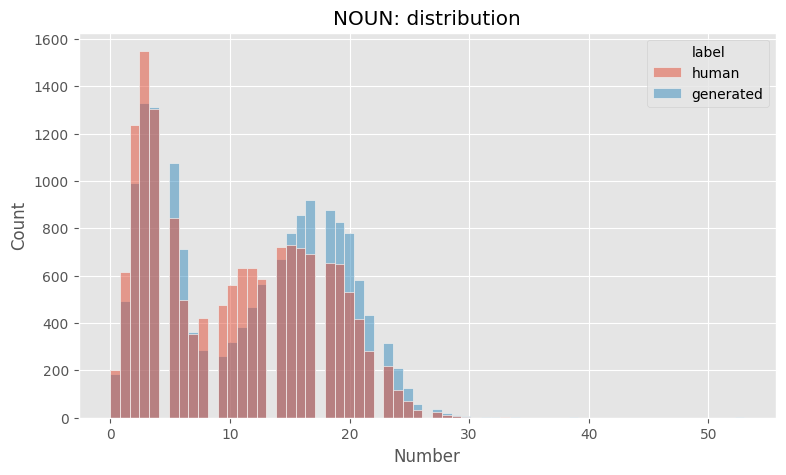

################################################################################


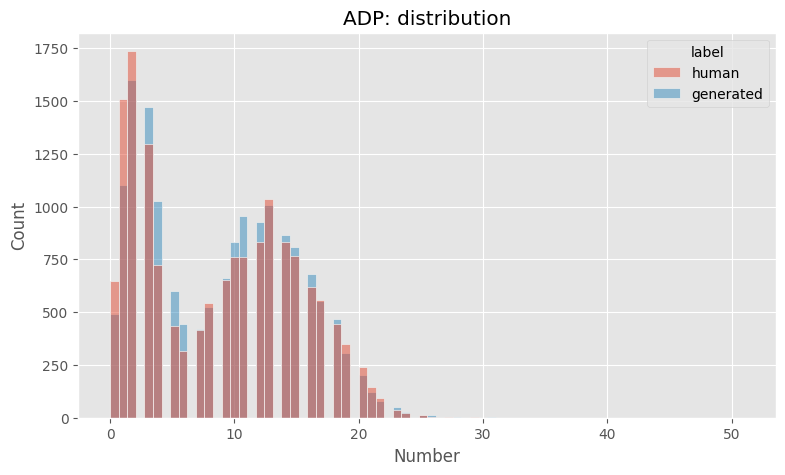

################################################################################


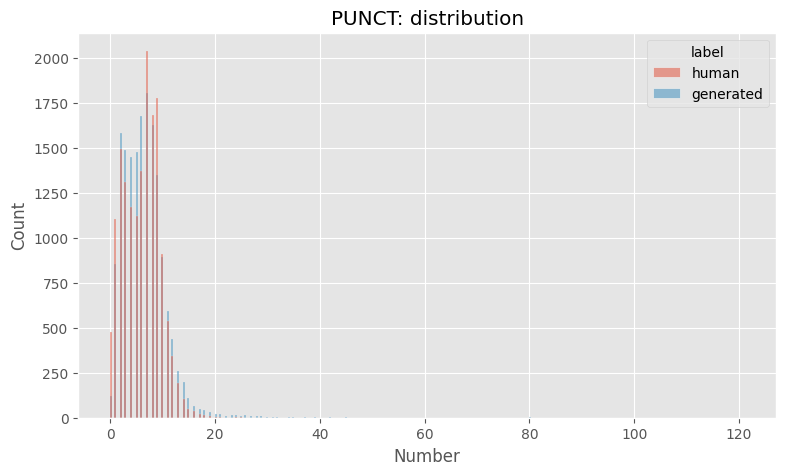

################################################################################


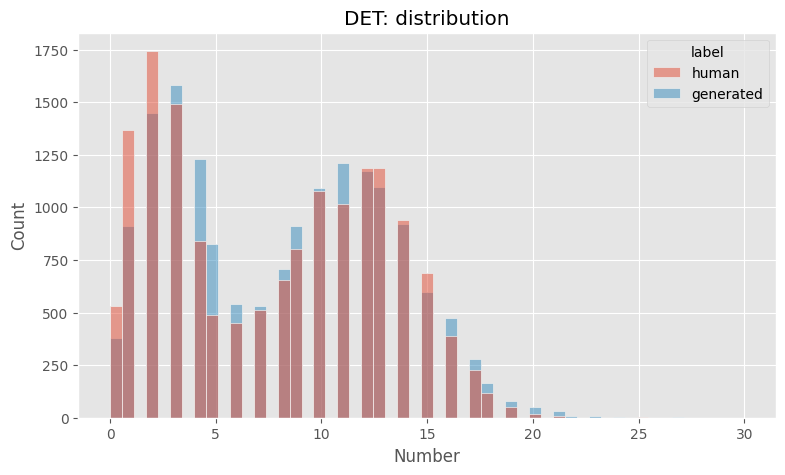

################################################################################


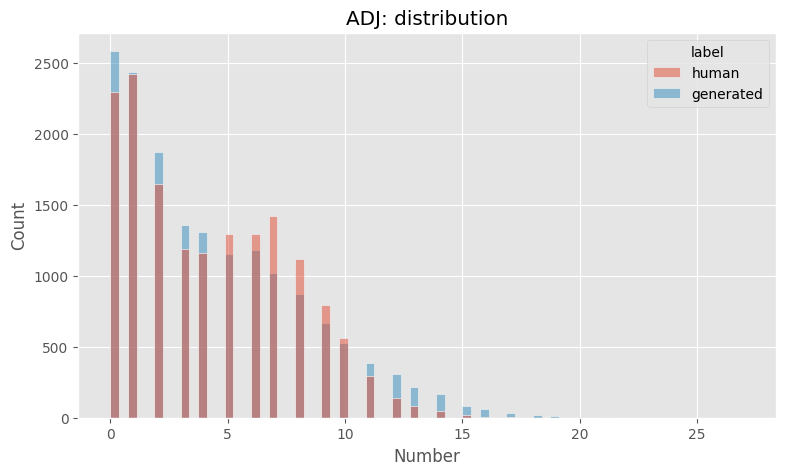

################################################################################


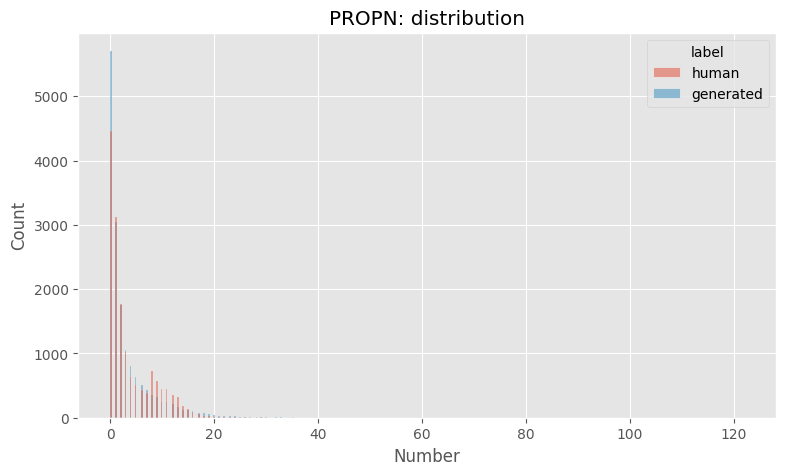

################################################################################


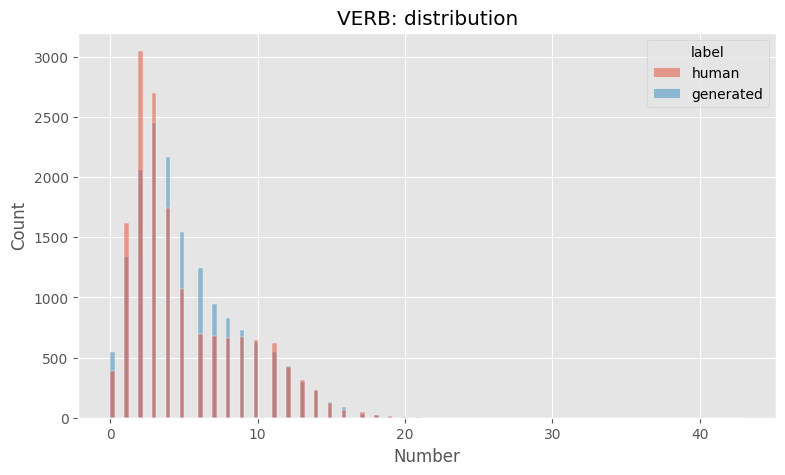

################################################################################


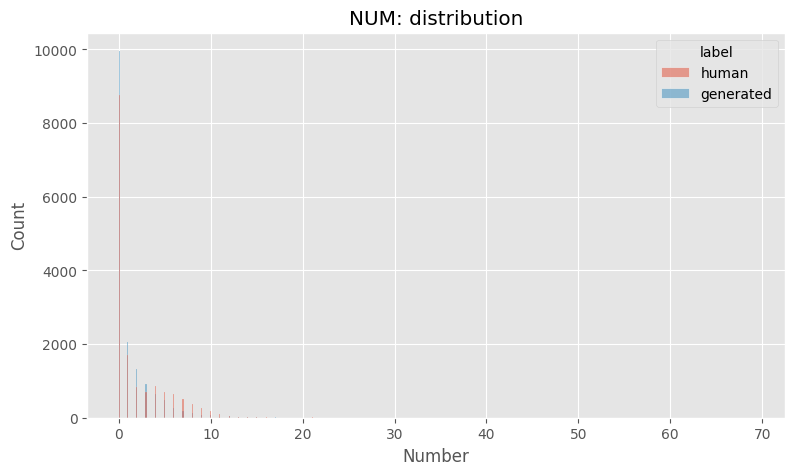

################################################################################


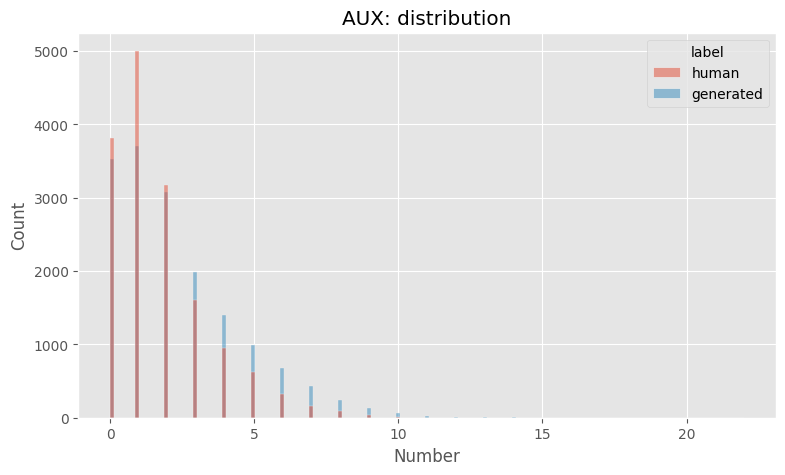

################################################################################


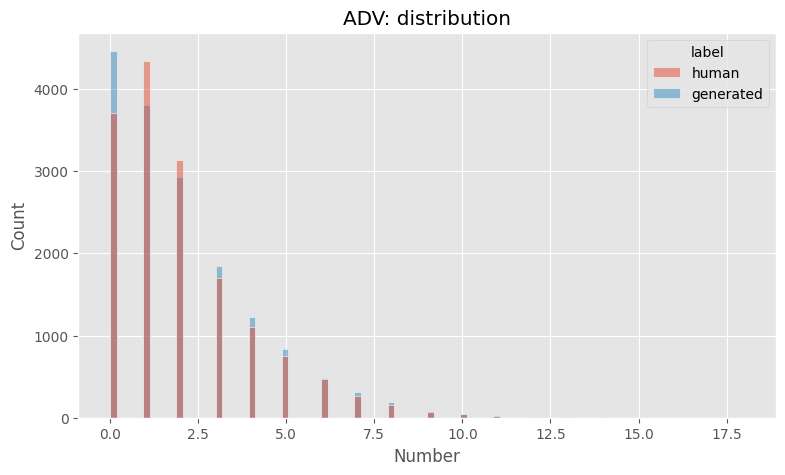

################################################################################


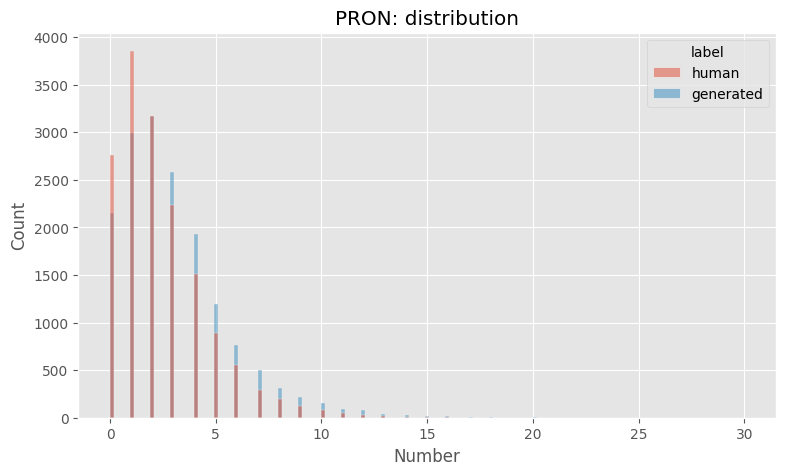

################################################################################


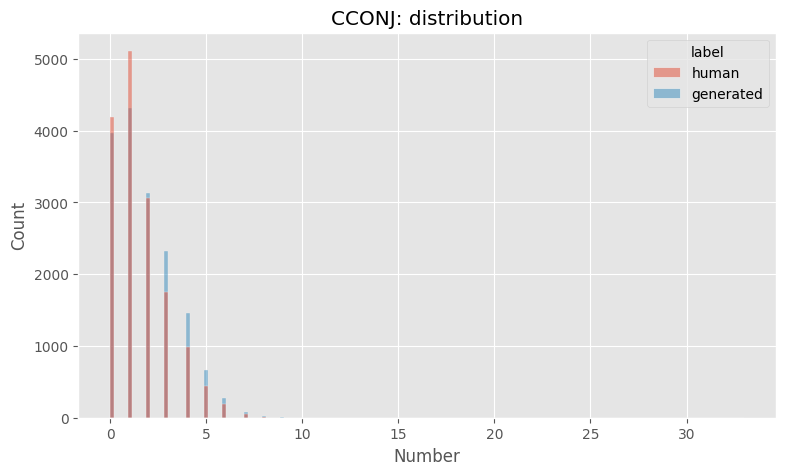

################################################################################


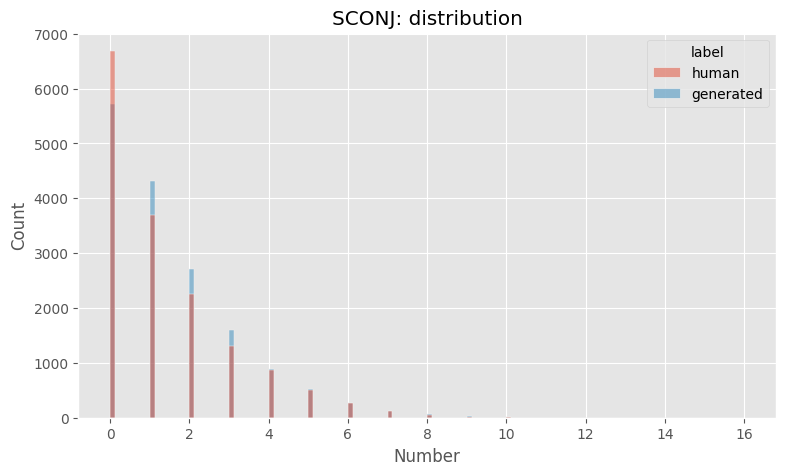

################################################################################


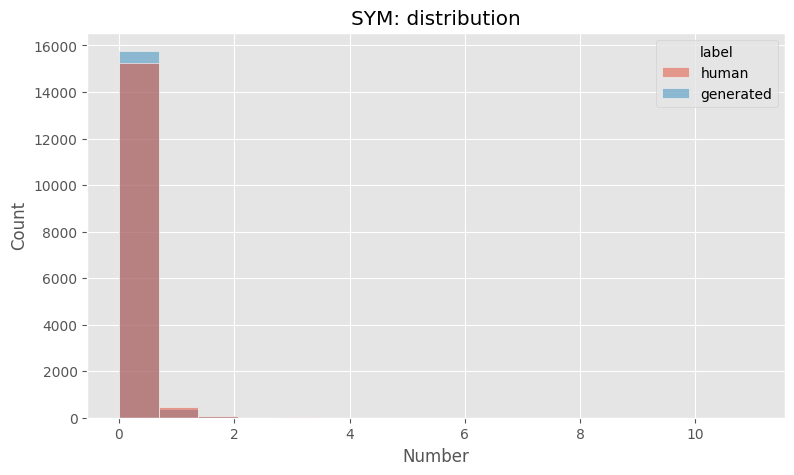

################################################################################


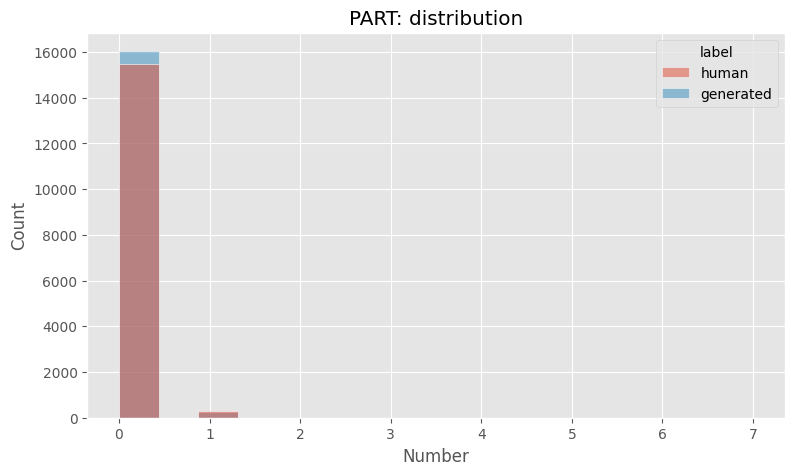

################################################################################


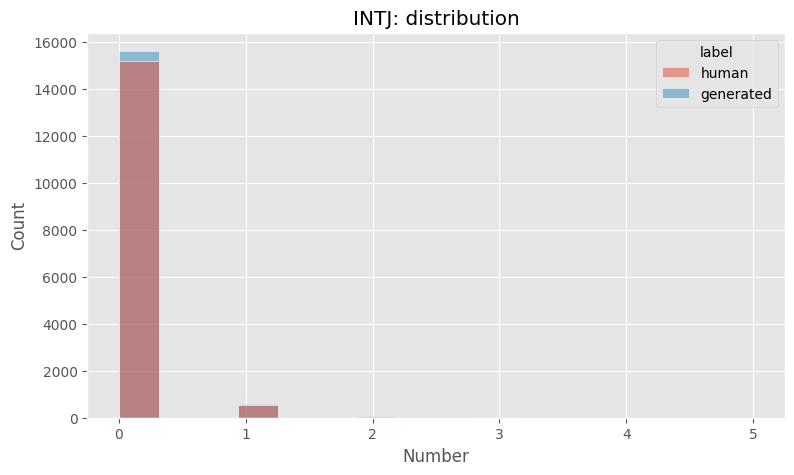

################################################################################


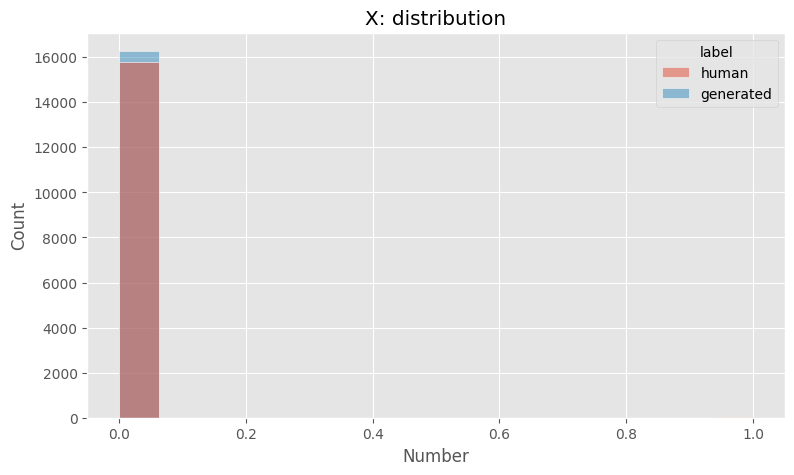

################################################################################


In [ ]:
for pos in pos_list:
    plt.figure(figsize=(9, 5))
    sns.histplot(data=train_df_filtered_es, x=pos, hue="label")
    plt.xlabel('Number')
    plt.title(pos + ": distribution")
    plt.show()
    print("#" * 80)

### English

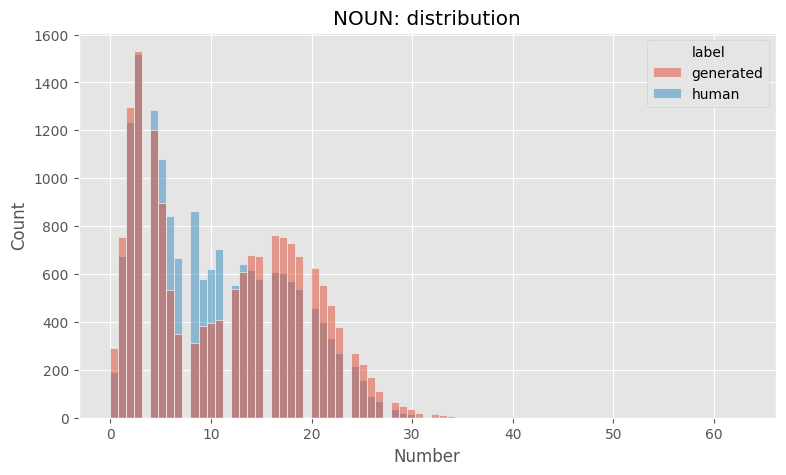

################################################################################


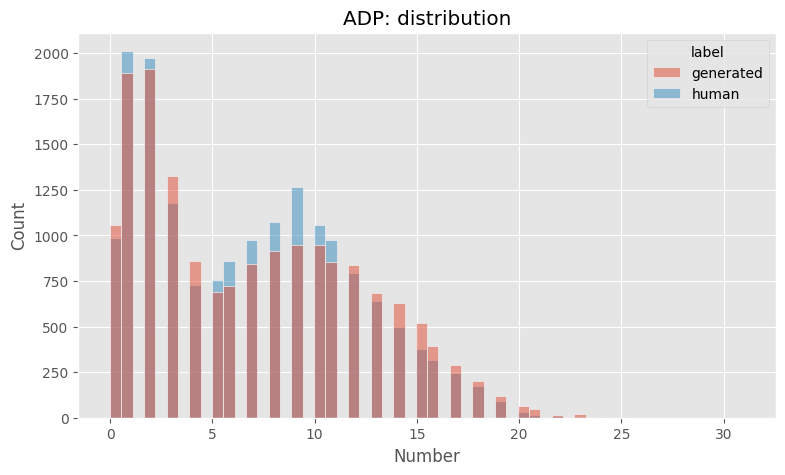

################################################################################


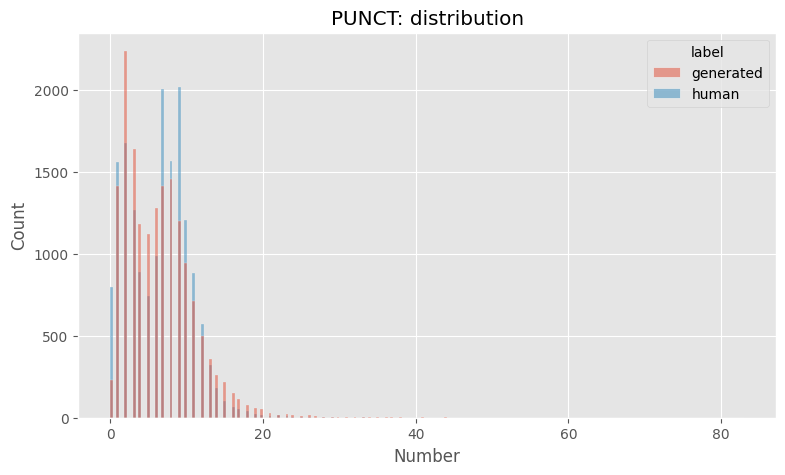

################################################################################


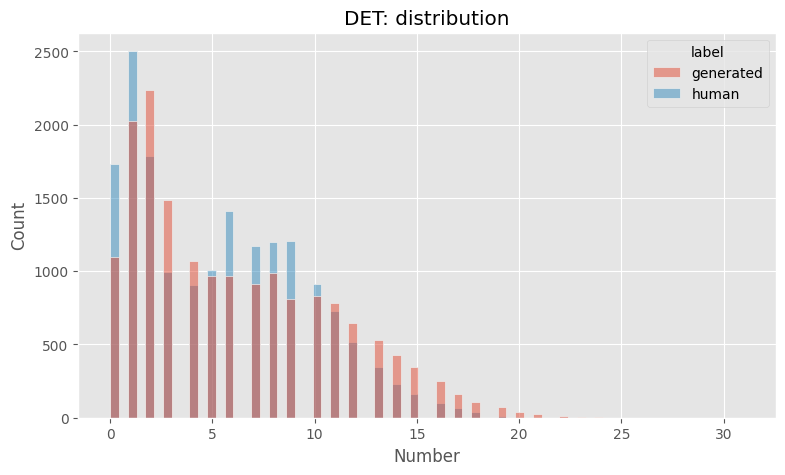

################################################################################


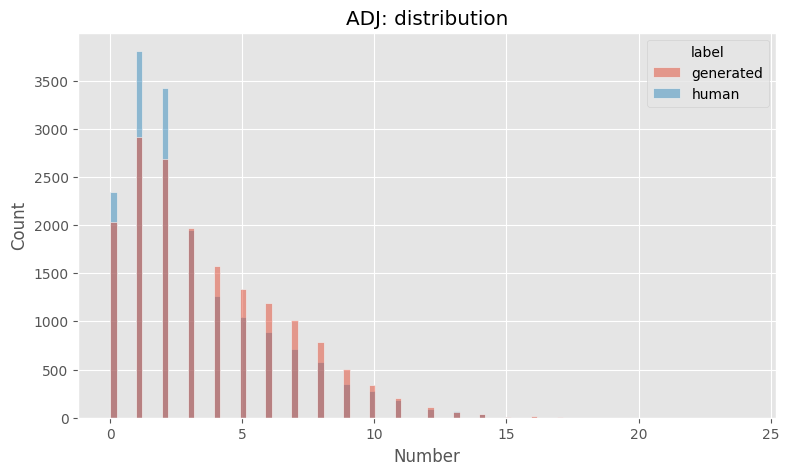

################################################################################


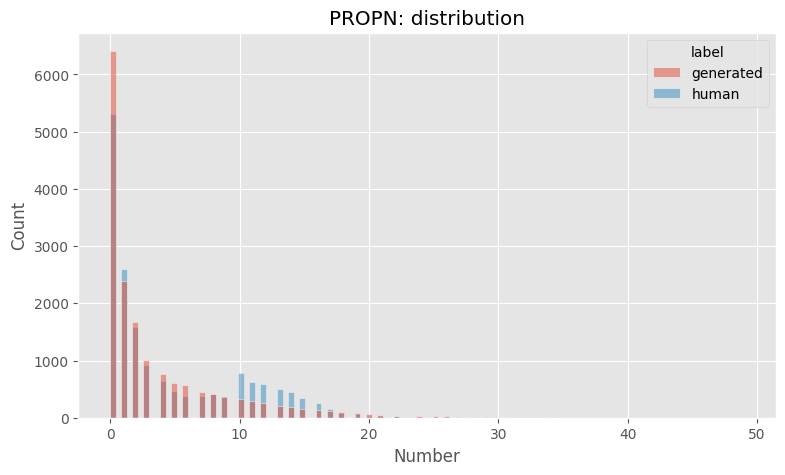

################################################################################


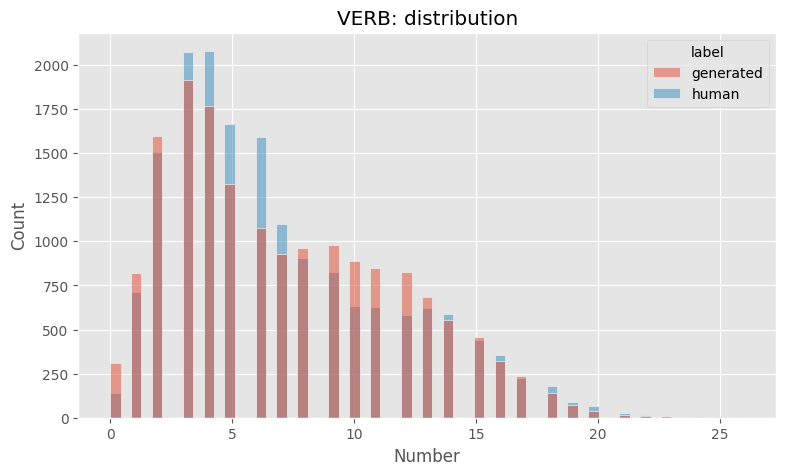

################################################################################


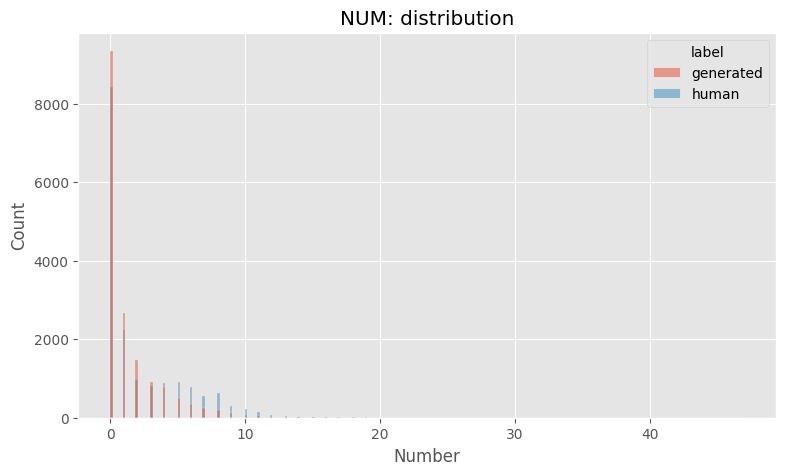

################################################################################


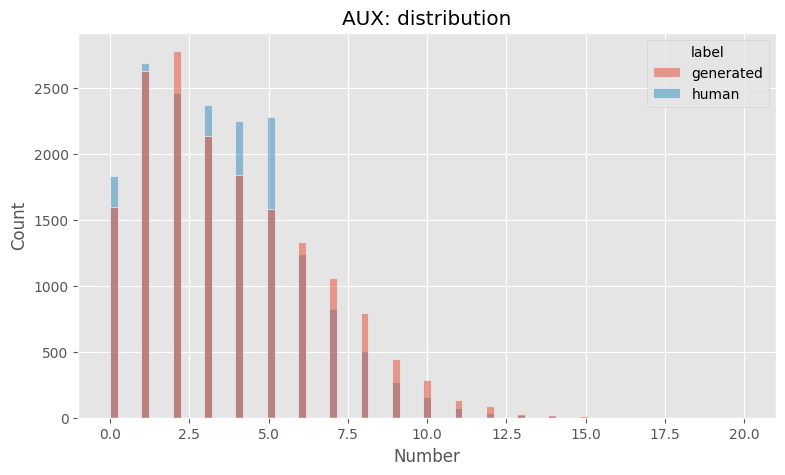

################################################################################


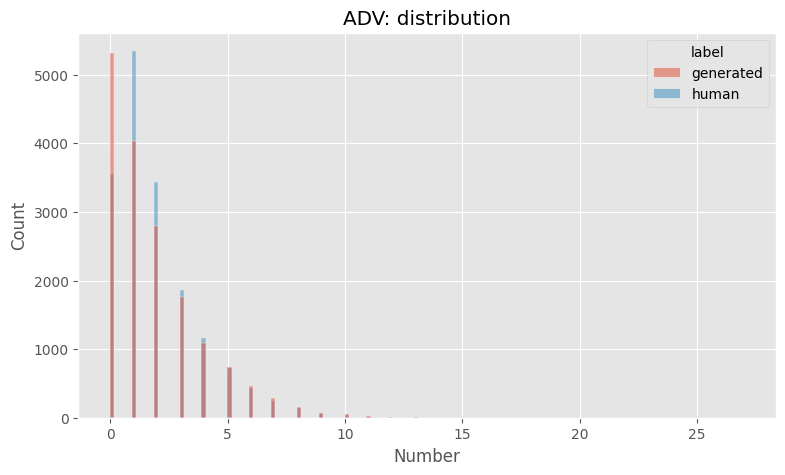

################################################################################


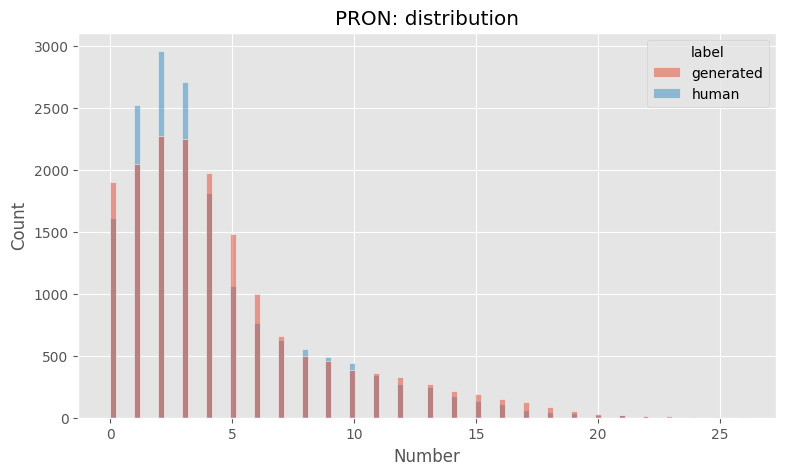

################################################################################


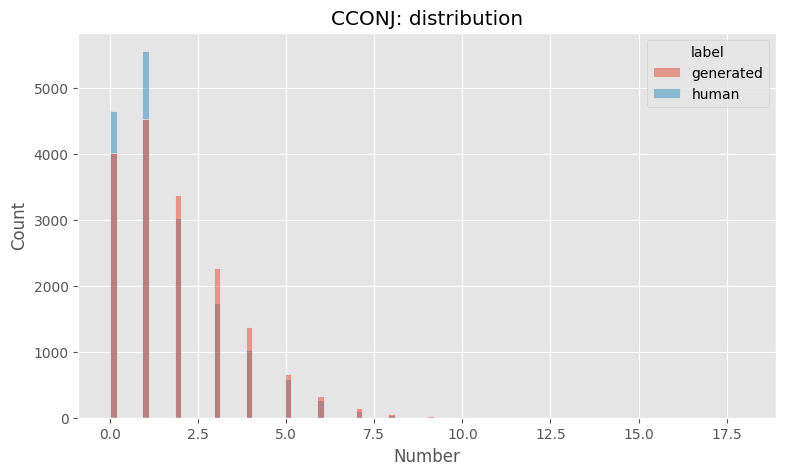

################################################################################


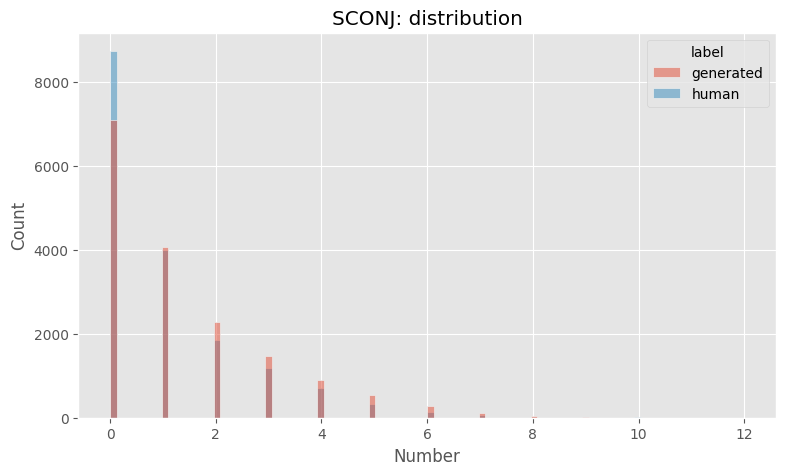

################################################################################


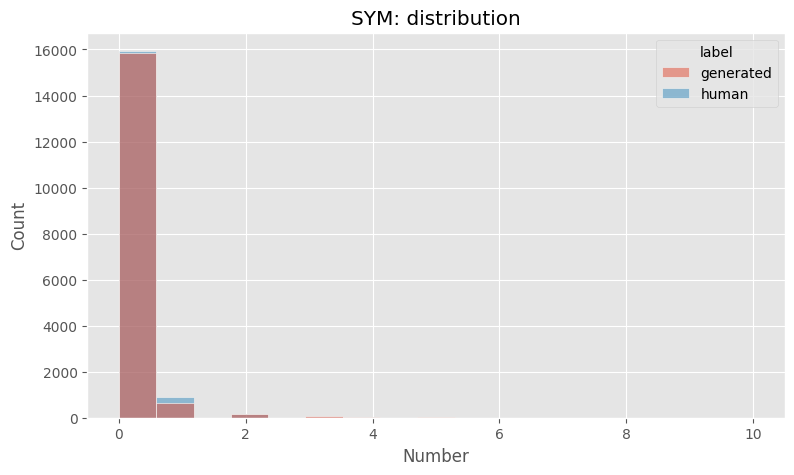

################################################################################


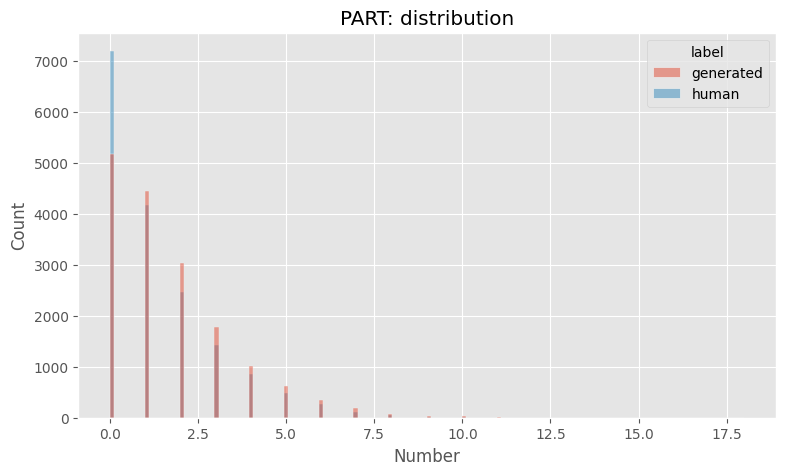

################################################################################


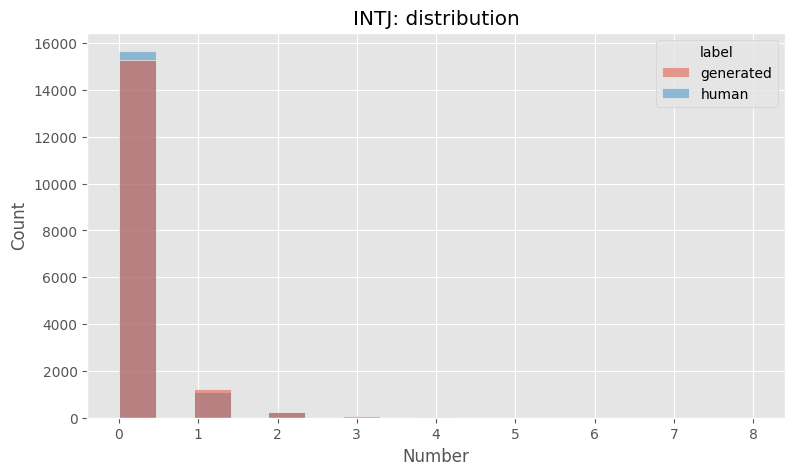

################################################################################


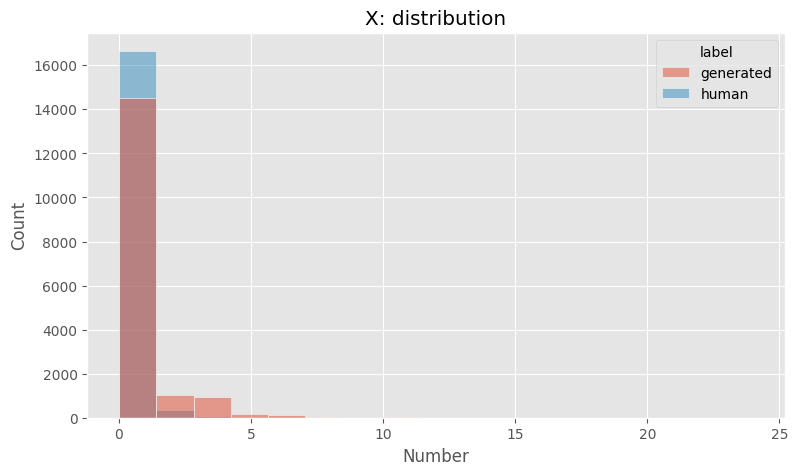

################################################################################


In [ ]:
for pos in pos_list:
  plt.figure(figsize=(9, 5))
  sns.histplot(data=train_df_filtered_en, x=pos, hue="label")
  plt.xlabel('Number')
  plt.title(pos + ": distribution")
  plt.show()
  print("#" * 80)

## Text comprenhension

|Score|Difficulty|
|-----|----------|
|90-100|	Very Easy|
|80-89|	Easy|
|70-79|	Fairly Easy|
|60-69|	Standard|
|50-59|	Fairly Difficult|
|30-49|	Difficult|
|0-29|	Very Confusing|

In [131]:
train_df_filtered_es['fe_flesch_reading_ease'] = train_df_filtered_es['text'].progress_apply(lambda x: textstat.flesch_reading_ease(x))
train_df_filtered_en['fe_flesch_reading_ease'] = train_df_filtered_en['text'].progress_apply(lambda x: textstat.flesch_reading_ease(x))

100%|██████████| 32062/32062 [00:06<00:00, 4892.98it/s]


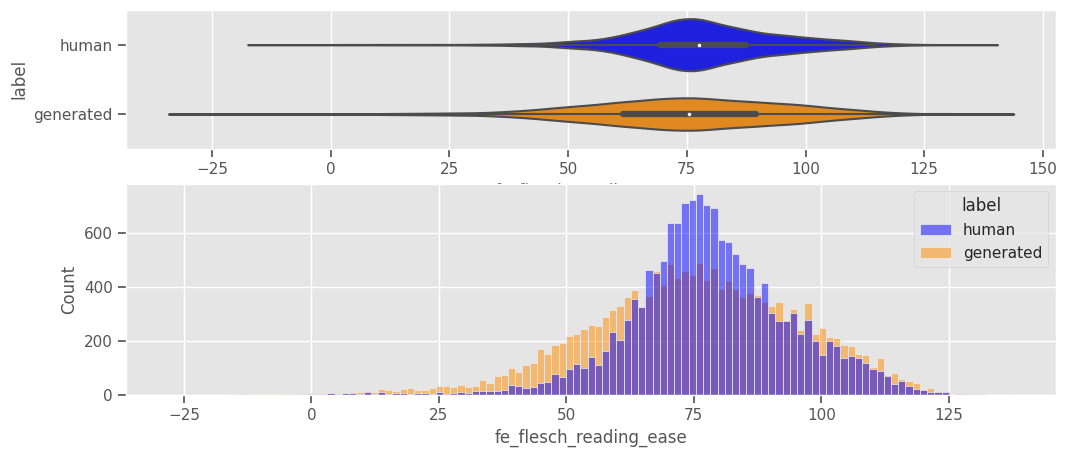

             count       mean        std     min    25%    50%    75%     max

label                                                                        

generated  16275.0  74.736191  21.740563 -545.21  61.57  75.40  89.60  137.78

human      15787.0  78.185253  16.240934  -12.77  69.28  77.51  87.56  135.74

Valor t: -16.05582709394715

Valor p: 8.748527303959519e-58

################################################################################


In [132]:
col = 'fe_flesch_reading_ease'

train_df_filtered_es_1 = train_df_filtered_es[train_df_filtered_es['label'] == 'generated'].reset_index(drop=True)[col]
train_df_filtered_es_0 = train_df_filtered_es[train_df_filtered_es['label'] == 'human'].reset_index(drop=True)[col]

# Realizar el t-test
t, p = ttest_ind(list(train_df_filtered_es_1), list(train_df_filtered_es_0))

color = {"generated": "darkorange", "human": "blue"}
f, (ax_box, ax_hist) = plt.subplots(2, figsize=(12, 5), gridspec_kw={"height_ratios": (.65, .99)})
sns.violinplot(data=train_df_filtered_es[train_df_filtered_es[col] > -200], x=col, ax=ax_box, width=0.75, y="label", palette=color) 
sns.histplot(data=train_df_filtered_es[train_df_filtered_es[col] > -200], x=col, hue="label", ax=ax_hist, palette=color)
plt.xlabel(col)
plt.show()

# Imprimir resultados
print(train_df_filtered_es.groupby('label')[col].describe())
print('Valor t:', t)
print('Valor p:', p)
print("#" * 80)

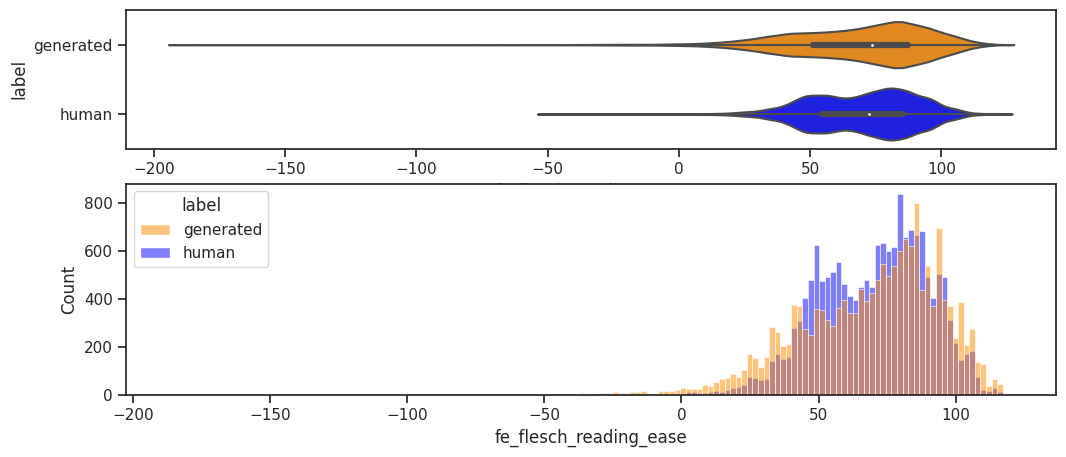

Valor t: -18.58369778478762

Valor p: 1.1022744795839767e-76

################################################################################


In [78]:
train_df_filtered_en_1 = train_df_filtered_en[train_df_filtered_en['label'] == 'generated'].reset_index(drop=True)[col]
train_df_filtered_en_0 = train_df_filtered_en[train_df_filtered_en['label'] == 'human'].reset_index(drop=True)[col]

# Realizar el t-test
t, p = ttest_ind(list(train_df_filtered_es_1), list(train_df_filtered_es_0))

color = {"generated": "darkorange", "human": "blue"}

f, (ax_box, ax_hist) = plt.subplots(2, figsize=(12, 5), gridspec_kw={"height_ratios": (.65, .99)})
sns.violinplot(data=train_df_filtered_en[train_df_filtered_en[col] > -200], x=col, ax=ax_box, width=0.75, y="label", palette=color) 
sns.histplot(data=train_df_filtered_en[train_df_filtered_en[col] > -200], x=col, hue="label", ax=ax_hist, palette=color)
plt.xlabel(col)
plt.show()

# Imprimir resultados
print('Valor t:', t)
print('Valor p:', p)
print("#" * 80)

## Text legibility

### Spanish

* Fernández Huerta Score

|Puntos |Legibilidad |Nivel educativo|
|-------|------------|---------------|
|0-30 |muy difícil| universitario|
|30-50| difícil| preuniversitario|
|50-60| bastante difícil| 13-16 años|
|60-70| normal| 10-12 años|
|70-80| bastante| fácil 9 años|
|80-90| fácil| 6 años|
|90-100| muy fácil| 5 años|

* Szigriszt Pazos Score

|Puntos |Estilo |Tipo de publicación Estudios (audiencia)|
| ----- |-------|----------------------------------------|
|0 a 15 |muy difícil |Científica, filosófica titulados universitarios|
|16 a 35 |árido |Pedagógica, técnica selectividad y estudios universitarios|
|36 a 50 |bastante difícil |Literatura y divulgación cursos secundarios|
|51 a 65 |normal |Los media popular|
|66 a 75 |bastante fácil |Novela y revista femenina 12 años|
|76 a 85 |fácil |Para kioscos 11 años|
|86 a 100 |muy fácil |Cómics, tebeos, viñetas 6 a 10 años|

* [Gutierrez Polini score](https://legible.es/blog/comprensibilidad-gutierrez-de-polini/): C = 95,2 - (9.7 * L)/P - (0,35 * P)/F. C es la comprensibilidad del texto; L, el número de letras; P, el de palabras; F, el de frases.

* [Crawford score](https://legible.es/blog/formula-de-crawford/): Sirve para calcular los años de escolaridad necesarios para entender un texto. La ideó Alan N. Crawford en 1989 [1]. Solo vale para niños de primaria. La ecuación es así: A = -0,205 * OP + 0,049 * SP - 3,407. A es el número de años de escolarización; OP, el número de oraciones por cien palabras; SP, el número de sílabas por cien palabras. El resultado se redondea al décimo más cercano.

In [127]:
tqdm.pandas()
textstat.set_lang('es')
train_df_filtered_es['fe_fernandez_huerta_score'] = train_df_filtered_es['text'].progress_apply(lambda x: textstat.fernandez_huerta(x))
train_df_filtered_es['fe_szigriszt_pazos_score']  = train_df_filtered_es['text'].progress_apply(lambda x: textstat.szigriszt_pazos(x))
train_df_filtered_es['fe_gutierrez_polini_score'] = train_df_filtered_es['text'].progress_apply(lambda x: textstat.gutierrez_polini(x))
train_df_filtered_es['fe_crawford_score']         = train_df_filtered_es['text'].progress_apply(lambda x: textstat.crawford(x))

100%|██████████| 32062/32062 [00:12<00:00, 2649.07it/s]

100%|██████████| 32062/32062 [00:06<00:00, 5234.71it/s]

100%|██████████| 32062/32062 [00:02<00:00, 11006.39it/s]

100%|██████████| 32062/32062 [00:04<00:00, 6512.29it/s]


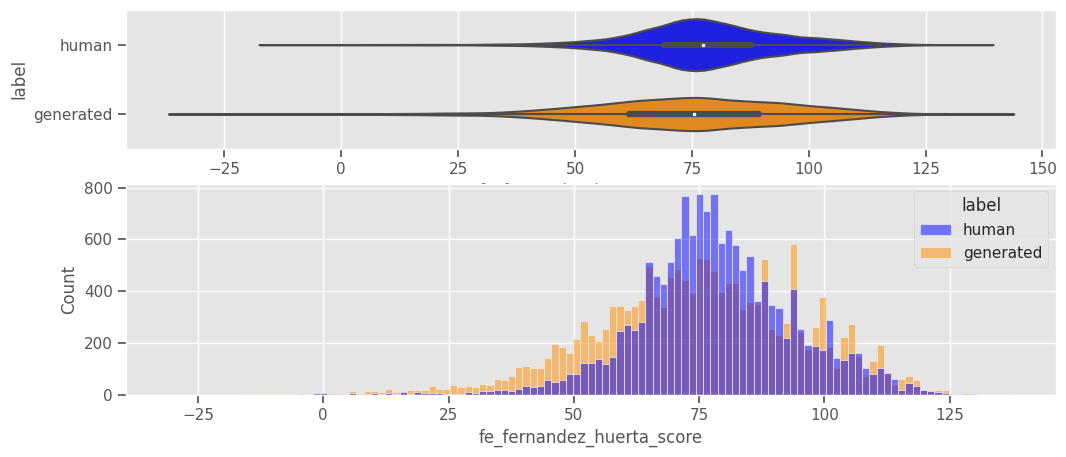

             count       mean        std     min    25%    50%    75%     max

label                                                                        

generated  16275.0  74.648903  21.770525 -545.21  61.46  75.50  89.34  137.78

human      15787.0  78.089676  16.294282  -12.89  69.10  77.42  87.62  134.72

Valor t: -15.984498557842038

Valor p: 2.730004398420985e-57

################################################################################


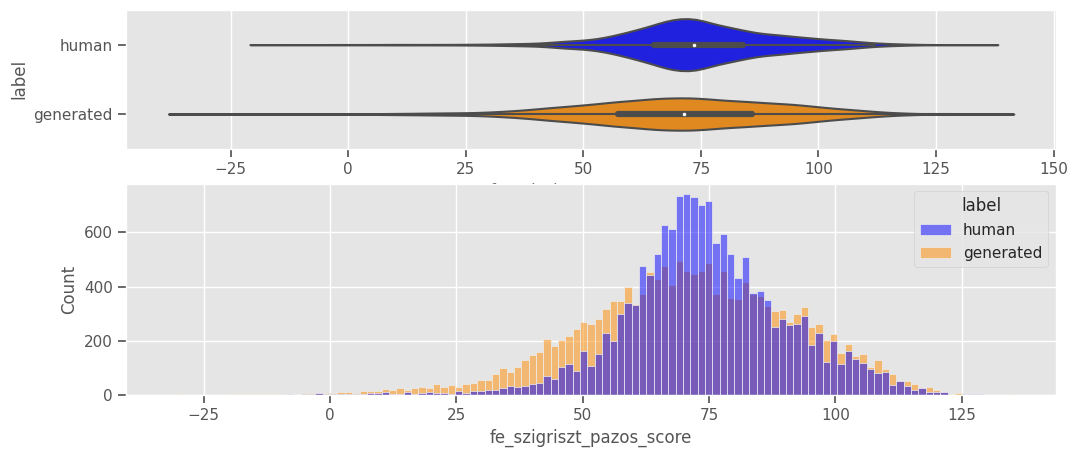

             count       mean        std     min     25%    50%    75%     max

label                                                                         

generated  16275.0  70.798442  22.110073 -573.92  57.315  71.39  85.87  135.35

human      15787.0  74.259665  16.536836  -16.09  65.085  73.45  83.85  133.35

Valor t: -15.836470683898533

Valor p: 2.850861009087144e-56

################################################################################


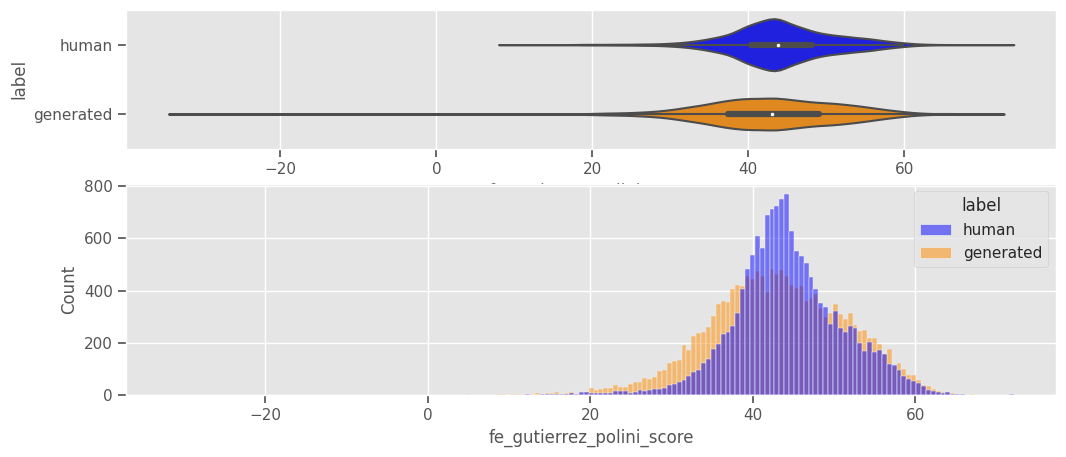

             count       mean       std     min     25%    50%    75%    max

label                                                                       

generated  16275.0  42.991024  8.830598 -249.86  37.435  42.98  49.10  70.36

human      15787.0  44.284176  6.735369    9.93  40.335  43.84  48.18  72.10

Valor t: -14.71117447398531

Valor p: 7.88786630677012e-49

################################################################################


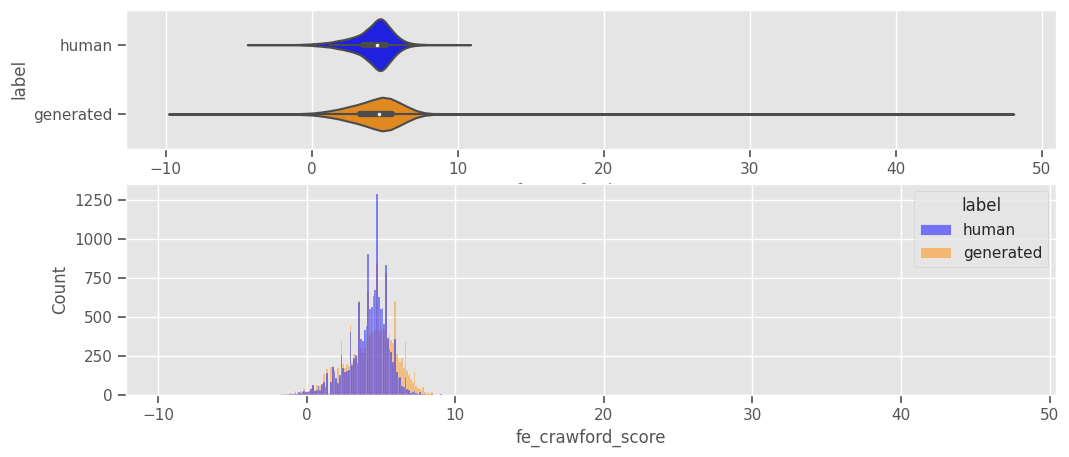

             count      mean       std  min  25%  50%  75%   max

label                                                           

generated  16275.0  4.352031  1.748136 -9.3  3.3  4.6  5.5  47.6

human      15787.0  4.203085  1.391361 -4.0  3.5  4.5  5.1  10.5

Valor t: 8.425326765192153

Valor p: 3.745516740654011e-17

################################################################################


In [128]:
for col in ['fe_fernandez_huerta_score', 'fe_szigriszt_pazos_score', 'fe_gutierrez_polini_score', 'fe_crawford_score']:
  # Realizar el t-test
  train_df_filtered_es_1 = train_df_filtered_es[train_df_filtered_es['label'] == 'generated'].reset_index(drop=True)[col]
  train_df_filtered_es_0 = train_df_filtered_es[train_df_filtered_es['label'] == 'human'].reset_index(drop=True)[col]

  # Realizar el t-test
  t, p = ttest_ind(list(train_df_filtered_es_1), list(train_df_filtered_es_0))

  f, (ax_box, ax_hist) = plt.subplots(2, figsize=(12, 5), gridspec_kw={"height_ratios": (.65, .99)})
  sns.violinplot(data=train_df_filtered_es[train_df_filtered_es[col] > -200], x=col, ax=ax_box, width=0.75, y="label", palette=color) 
  sns.histplot(data=train_df_filtered_es[train_df_filtered_es[col] > -200], x=col, hue="label", ax=ax_hist, palette=color)
  plt.xlabel(col)
  plt.show()

  # Imprimir resultados
  print(train_df_filtered_es.groupby('label')[col].describe())
  print('Valor t:', t)
  print('Valor p:', p)
  print("#" * 80)

### English

In [90]:
tqdm.pandas()
train_df_filtered_en['fe_dale_chall_readability_score'] = train_df_filtered_en['text'].progress_apply(lambda x: textstat.dale_chall_readability_score(x))
train_df_filtered_en['fe_spache_readability_score']     = train_df_filtered_en['text'].progress_apply(lambda x: textstat.spache_readability(x))
train_df_filtered_en['fe_mcalpine_eflaw_score']         = train_df_filtered_en['text'].progress_apply(lambda x: textstat.mcalpine_eflaw(x))

100%|██████████| 33845/33845 [00:10<00:00, 3188.56it/s]

100%|██████████| 33845/33845 [00:06<00:00, 5634.34it/s]

100%|██████████| 33845/33845 [00:01<00:00, 19826.26it/s]


* Dale Chall score:

![](https://wikimedia.org/api/rest_v1/media/math/render/svg/0541f1e629f0c06796c5a5babb3fac8d100a858c)

|Score	|Notes|
| ------|-----|
|4.9 or lower	|easily understood by an average 4th-grade student or lower|
|5.0–5.9	|easily understood by an average 5th- or 6th-grade student|
|6.0–6.9	|easily understood by an average 7th- or 8th-grade student|
|7.0–7.9	|easily understood by an average 9th- or 10th-grade student|
|8.0–8.9	|easily understood by an average 11th- or 12th-grade student|
|9.0–9.9	|easily understood by an average college student|

* Spache readibility score: Returns grade level of english text.

![](https://wikimedia.org/api/rest_v1/media/math/render/svg/3f150b917fe80e6ed0a4b4b17d217b4bbe0a5f36)

* McAlpine EFLAW Readability Score: Returns a score for the readability of an english text for a foreign learner or English, focusing on the number of miniwords and length of sentences.
And here is the scale: 1-20 (very easy to understand); 21-25 (quite easy to understand); 26-29 (a little difficult); and 30+ (very confusing).    


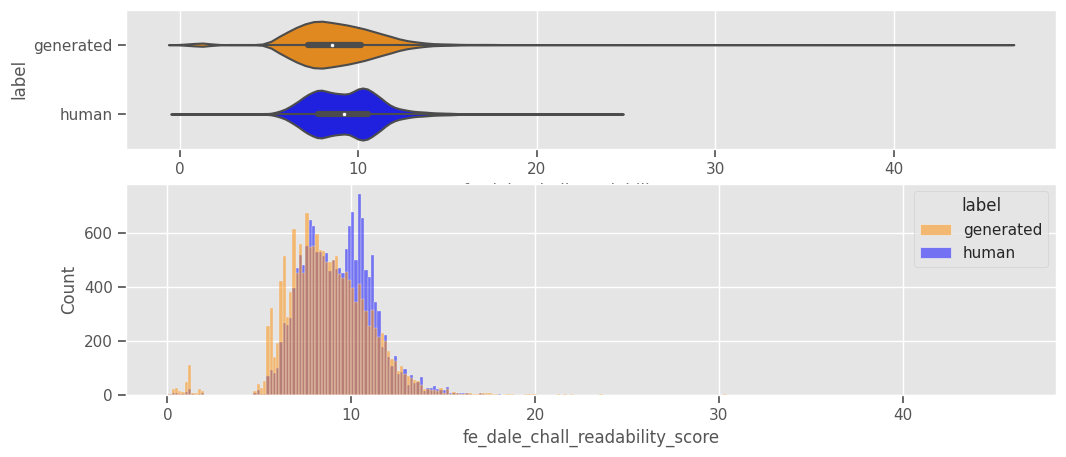

             count      mean       std   min   25%   50%    75%     max

label                                                                  

generated  16799.0  8.737817  2.565082  0.05  7.20  8.53  10.16  122.16

human      17046.0  9.246187  1.968605  0.05  7.77  9.21  10.55   24.29

Valor t: -20.471402152415113

Valor p: 1.4111157717942278e-92

################################################################################


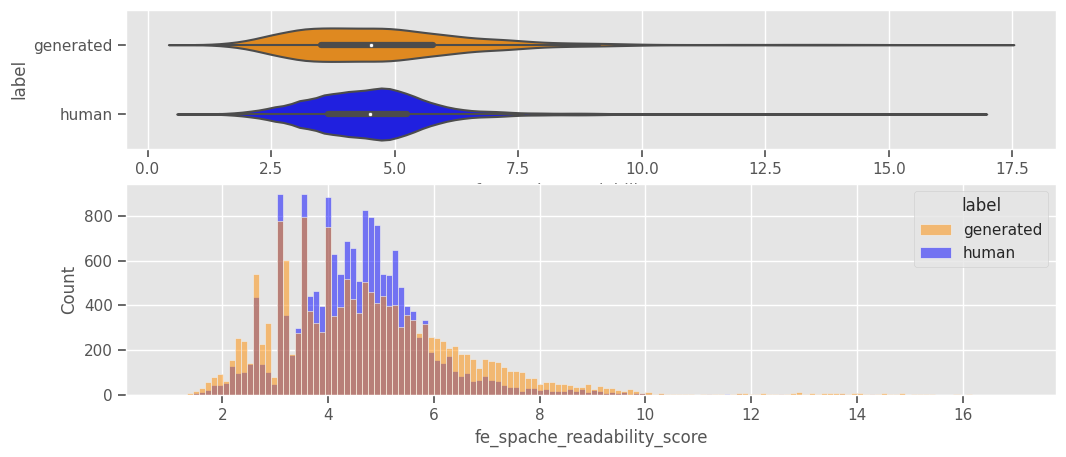

             count      mean       std   min   25%   50%   75%    max

label                                                                

generated  16799.0  4.817930  1.952595  0.98  3.51  4.53  5.77  16.97

human      17046.0  4.559657  1.366256  0.98  3.65  4.50  5.24  16.59

Valor t: 14.115506649438862

Valor p: 4.094265384867457e-45

################################################################################


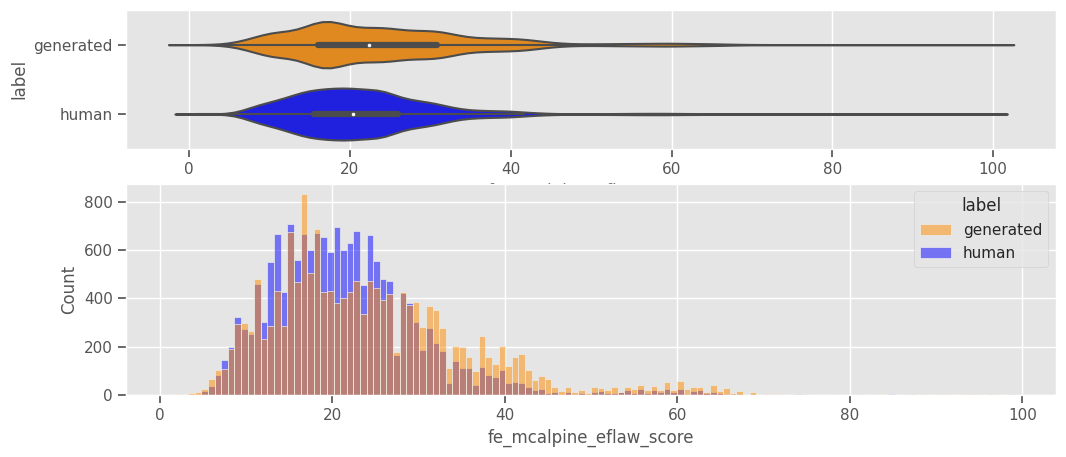

             count       mean        std  min   25%   50%   75%    max

label                                                                 

generated  16799.0  25.763861  15.709133  1.0  16.3  22.6  31.0  159.0

human      17046.0  22.045125  10.788851  1.0  15.5  20.4  26.0  134.0

Valor t: 25.417162545844587

Valor p: 3.453788193411871e-141

################################################################################


In [126]:
for col in ['fe_dale_chall_readability_score', 'fe_spache_readability_score', 'fe_mcalpine_eflaw_score']:
  # Realizar el t-test
  train_df_filtered_en_1 = train_df_filtered_en[train_df_filtered_en['label'] == 'generated'].reset_index(drop=True)[col]
  train_df_filtered_en_0 = train_df_filtered_en[train_df_filtered_en['label'] == 'human'].reset_index(drop=True)[col]

  # Realizar el t-test
  t, p = ttest_ind(list(train_df_filtered_en_1), list(train_df_filtered_en_0))

  f, (ax_box, ax_hist) = plt.subplots(2, figsize=(12, 5), gridspec_kw={"height_ratios": (.65, .99)})
  sns.violinplot(data=train_df_filtered_en[train_df_filtered_en[col] < 100], x=col, ax=ax_box, width=0.75, y="label", palette=color) 
  sns.histplot(data=train_df_filtered_en[train_df_filtered_en[col] < 100], x=col, hue="label", ax=ax_hist, palette=color)
  plt.xlabel(col)
  plt.show()

  # Imprimir resultados
  print(train_df_filtered_en.groupby('label')[col].describe())
  print('Valor t:', t)
  print('Valor p:', p)
  print("#" * 80)

## Reading time

In [129]:
train_df_filtered_es['fe_reading_time'] = train_df_filtered_es['text'].progress_apply(lambda x: textstat.reading_time(x, ms_per_char=14.69))
train_df_filtered_en['fe_reading_time'] = train_df_filtered_en['text'].progress_apply(lambda x: textstat.reading_time(x, ms_per_char=14.69))

100%|██████████| 32062/32062 [00:00<00:00, 56058.80it/s]


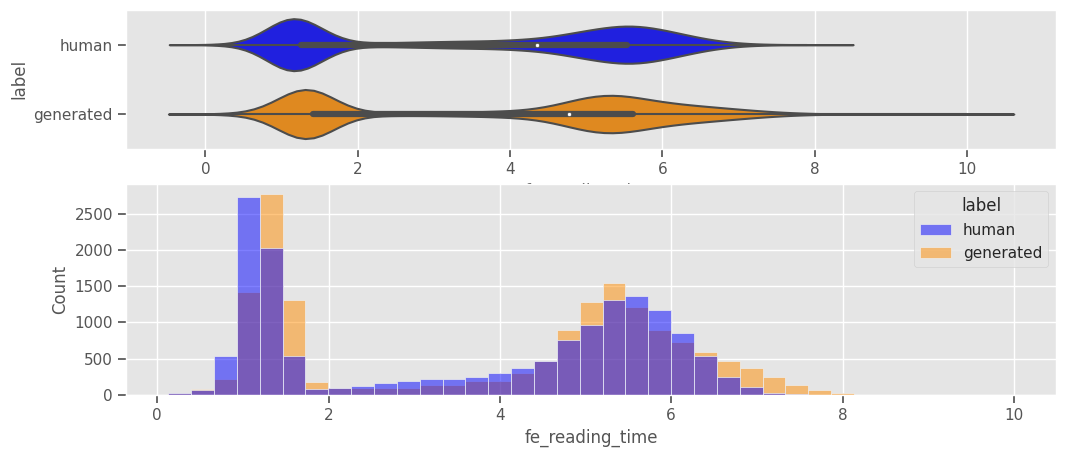

             count      mean       std   min   25%   50%   75%   max

label                                                               

generated  16275.0  3.882467  2.144521  0.13  1.41  4.77  5.61  10.0

human      15787.0  3.634067  2.093555  0.13  1.25  4.36  5.54   7.9

Valor t: 10.491016631340681

Valor p: 1.0456763633278665e-25

################################################################################


In [130]:
col = 'fe_reading_time'
# Realizar el t-test
train_df_filtered_es_1 = train_df_filtered_es[train_df_filtered_es['label'] == 'generated'].reset_index(drop=True)[col]
train_df_filtered_es_0 = train_df_filtered_es[train_df_filtered_es['label'] == 'human'].reset_index(drop=True)[col]

# Realizar el t-test
t, p = ttest_ind(list(train_df_filtered_es_1), list(train_df_filtered_es_0))

color = {"generated": "darkorange", "human": "blue"}
f, (ax_box, ax_hist) = plt.subplots(2, figsize=(12, 5), gridspec_kw={"height_ratios": (.65, .99)})
sns.violinplot(data=train_df_filtered_es[train_df_filtered_es[col] > -200], x=col, ax=ax_box, width=0.75, y="label", palette=color) 
sns.histplot(data=train_df_filtered_es[train_df_filtered_es[col] > -200], x=col, hue="label", ax=ax_hist, palette=color)
plt.xlabel(col)
plt.show()

# Imprimir resultados
print(train_df_filtered_es.groupby('label')[col].describe())
print('Valor t:', t)
print('Valor p:', p)
print("#" * 80)

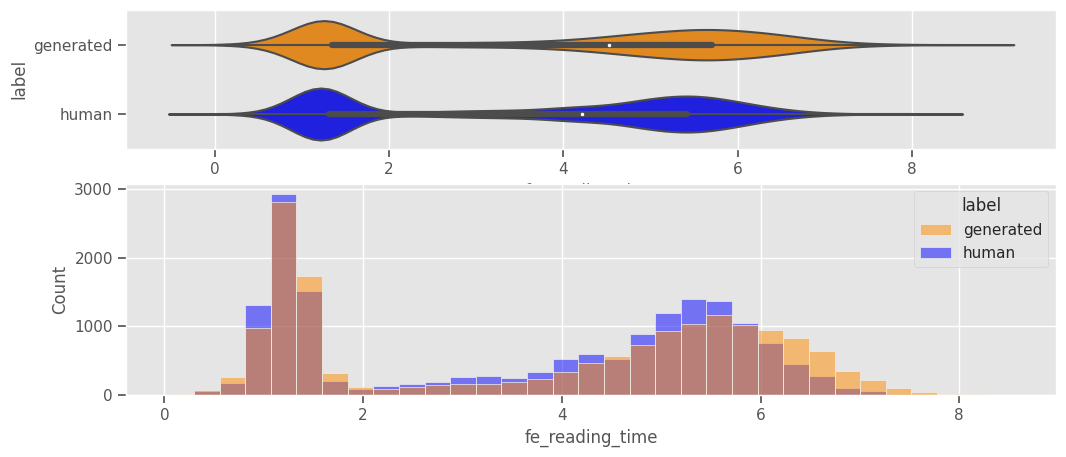

             count      mean       std   min   25%   50%   75%   max

label                                                               

generated  16799.0  3.810468  2.171666  0.12  1.34  4.52  5.71  8.55

human      17046.0  3.612033  2.009465  0.04  1.31  4.22  5.42  8.01

Valor t: 8.726834455440793

Valor p: 2.7365293582086012e-18

################################################################################


In [122]:
col = 'fe_reading_time'
# Realizar el t-test
train_df_filtered_en_1 = train_df_filtered_en[train_df_filtered_en['label'] == 'generated'].reset_index(drop=True)[col]
train_df_filtered_en_0 = train_df_filtered_en[train_df_filtered_en['label'] == 'human'].reset_index(drop=True)[col]

# Realizar el t-test
t, p = ttest_ind(list(train_df_filtered_en_1), list(train_df_filtered_en_0))

color = {"generated": "darkorange", "human": "blue"}
f, (ax_box, ax_hist) = plt.subplots(2, figsize=(12, 5), gridspec_kw={"height_ratios": (.65, .99)})
sns.violinplot(data=train_df_filtered_en[train_df_filtered_en[col] > -200], x=col, ax=ax_box, width=0.75, y="label", palette=color) 
sns.histplot(data=train_df_filtered_en[train_df_filtered_en[col] > -200], x=col, hue="label", ax=ax_hist, palette=color)
plt.xlabel(col)
plt.show()

# Imprimir resultados
print(train_df_filtered_en.groupby('label')[col].describe())
print('Valor t:', t)
print('Valor p:', p)
print("#" * 80)

## Grammar errors

In [119]:
spell = SpellChecker(language='en')
train_df_filtered_en['fe_number_errors'] = train_df_filtered_en['text'].progress_apply(lambda x: len(spell.unknown(x.split())))
spell = SpellChecker(language='es')
train_df_filtered_es['fe_number_errors'] = train_df_filtered_es['text'].progress_apply(lambda x: len(spell.unknown(x.split())))

100%|██████████| 33845/33845 [00:05<00:00, 6438.34it/s]

100%|██████████| 32062/32062 [00:03<00:00, 8760.55it/s]


### English

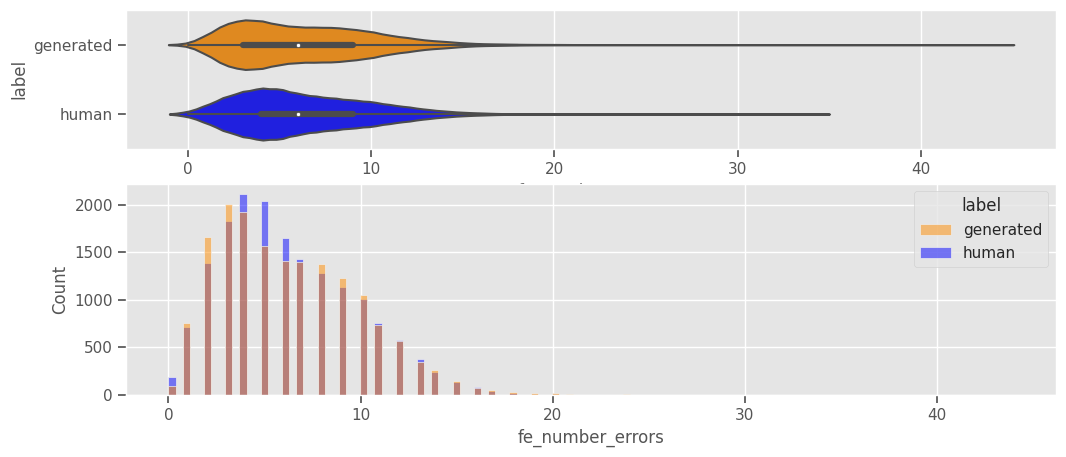

             count      mean       std  min  25%  50%  75%   max

label                                                           

generated  16799.0  6.325972  3.727350  0.0  3.0  6.0  9.0  44.0

human      17046.0  6.262760  3.540174  0.0  4.0  6.0  9.0  34.0

Valor t: 1.5998809378981245

Valor p: 0.10963433325216472

################################################################################


In [120]:
col = 'fe_number_errors'
# Realizar el t-test
train_df_filtered_en_1 = train_df_filtered_en[train_df_filtered_en['label'] == 'generated'].reset_index(drop=True)[col]
train_df_filtered_en_0 = train_df_filtered_en[train_df_filtered_en['label'] == 'human'].reset_index(drop=True)[col]

# Realizar el t-test
t, p = ttest_ind(list(train_df_filtered_en_1), list(train_df_filtered_en_0))

color = {"generated": "darkorange", "human": "blue"}
f, (ax_box, ax_hist) = plt.subplots(2, figsize=(12, 5), gridspec_kw={"height_ratios": (.65, .99)})
sns.violinplot(data=train_df_filtered_en[train_df_filtered_en[col] > -200], x=col, ax=ax_box, width=0.75, y="label", palette=color) 
sns.histplot(data=train_df_filtered_en[train_df_filtered_en[col] > -200], x=col, hue="label", ax=ax_hist, palette=color)
plt.xlabel(col)
plt.show()

# Imprimir resultados
print(train_df_filtered_en.groupby('label')[col].describe())
print('Valor t:', t)
print('Valor p:', p)
print("#" * 80)

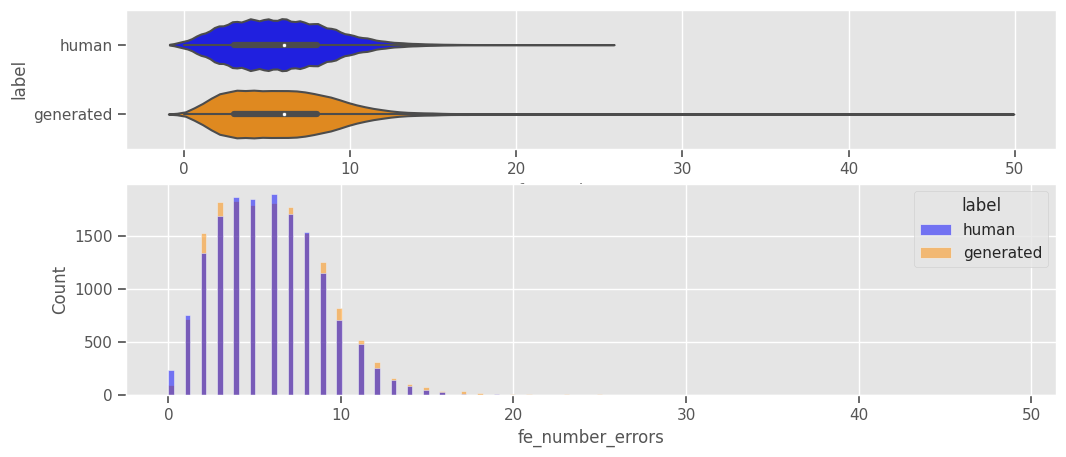

             count      mean       std  min  25%  50%  75%   max

label                                                           

generated  16275.0  5.980338  3.291870  0.0  3.0  6.0  8.0  49.0

human      15787.0  5.783049  3.054677  0.0  3.0  6.0  8.0  25.0

Valor t: 5.558528387530027

Valor p: 2.7422055918708677e-08

################################################################################


In [121]:
# Realizar el t-test
train_df_filtered_es_1 = train_df_filtered_es[train_df_filtered_es['label'] == 'generated'].reset_index(drop=True)[col]
train_df_filtered_es_0 = train_df_filtered_es[train_df_filtered_es['label'] == 'human'].reset_index(drop=True)[col]

# Realizar el t-test
t, p = ttest_ind(list(train_df_filtered_es_1), list(train_df_filtered_es_0))

color = {"generated": "darkorange", "human": "blue"}
f, (ax_box, ax_hist) = plt.subplots(2, figsize=(12, 5), gridspec_kw={"height_ratios": (.65, .99)})
sns.violinplot(data=train_df_filtered_es[train_df_filtered_es[col] > -200], x=col, ax=ax_box, width=0.75, y="label", palette=color) 
sns.histplot(data=train_df_filtered_es[train_df_filtered_es[col] > -200], x=col, hue="label", ax=ax_hist, palette=color)
plt.xlabel(col)
plt.show()

# Imprimir resultados
print(train_df_filtered_es.groupby('label')[col].describe())
print('Valor t:', t)
print('Valor p:', p)
print("#" * 80)

## General info.

In [103]:
train_df_filtered_es['fe_syllable_count'] = train_df_filtered_es['text'].progress_apply(lambda x: textstat.syllable_count(x))
train_df_filtered_en['fe_syllable_count'] = train_df_filtered_en['text'].progress_apply(lambda x: textstat.syllable_count(x))

train_df_filtered_es['fe_lexicon_count'] = train_df_filtered_es['text'].progress_apply(lambda x: textstat.lexicon_count(x))
train_df_filtered_en['fe_lexicon_count'] = train_df_filtered_en['text'].progress_apply(lambda x: textstat.lexicon_count(x))

train_df_filtered_es['fe_sentence_count'] = train_df_filtered_es['text'].progress_apply(lambda x: textstat.sentence_count(x))
train_df_filtered_en['fe_sentence_count'] = train_df_filtered_en['text'].progress_apply(lambda x: textstat.sentence_count(x))

train_df_filtered_es['fe_char_count'] = train_df_filtered_es['text'].progress_apply(lambda x: textstat.char_count(x, ignore_spaces=True))
train_df_filtered_en['fe_char_count'] = train_df_filtered_en['text'].progress_apply(lambda x: textstat.char_count(x, ignore_spaces=True))

train_df_filtered_es['fe_letter_count'] = train_df_filtered_es['text'].progress_apply(lambda x: textstat.letter_count(x, ignore_spaces=True))
train_df_filtered_en['fe_letter_count'] = train_df_filtered_en['text'].progress_apply(lambda x: textstat.letter_count(x, ignore_spaces=True))

train_df_filtered_es['fe_polysyllabcount'] = train_df_filtered_es['text'].progress_apply(lambda x: textstat.polysyllabcount(x))
train_df_filtered_en['fe_polysyllabcount'] = train_df_filtered_en['text'].progress_apply(lambda x: textstat.polysyllabcount(x))

train_df_filtered_es['fe_monosyllabcount'] = train_df_filtered_es['text'].progress_apply(lambda x: textstat.monosyllabcount(x))
train_df_filtered_en['fe_monosyllabcount'] = train_df_filtered_en['text'].progress_apply(lambda x: textstat.monosyllabcount(x))

100%|██████████| 32062/32062 [00:06<00:00, 5185.35it/s] 

100%|██████████| 33845/33845 [00:02<00:00, 11282.98it/s]

100%|██████████| 32062/32062 [00:00<00:00, 63907.15it/s]

100%|██████████| 33845/33845 [00:00<00:00, 74630.65it/s]

100%|██████████| 32062/32062 [00:00<00:00, 38531.92it/s]

100%|██████████| 33845/33845 [00:00<00:00, 39966.45it/s]

100%|██████████| 32062/32062 [00:00<00:00, 51897.90it/s]

100%|██████████| 33845/33845 [00:00<00:00, 55623.41it/s]

100%|██████████| 32062/32062 [00:00<00:00, 37025.55it/s]

100%|██████████| 33845/33845 [00:01<00:00, 24505.31it/s]

100%|██████████| 32062/32062 [00:05<00:00, 5415.01it/s]

100%|██████████| 33845/33845 [00:04<00:00, 7069.74it/s]

100%|██████████| 32062/32062 [00:05<00:00, 5424.38it/s]

100%|██████████| 33845/33845 [00:05<00:00, 6372.57it/s]


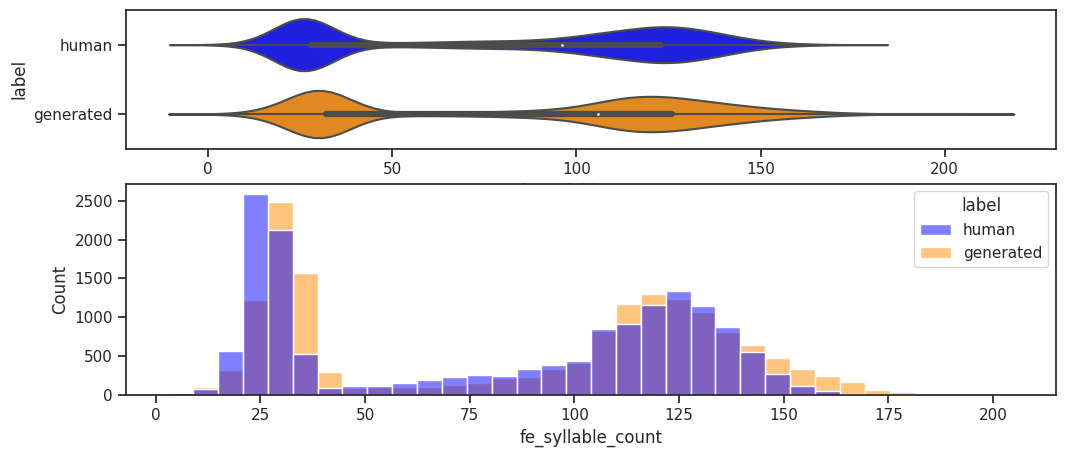

             count       mean        std  min   25%    50%    75%    max

label                                                                   

generated  16275.0  86.665253  47.981872  3.0  32.0  106.0  126.0  205.0

human      15787.0  80.715969  46.709325  3.0  28.0   96.0  123.0  171.0

t-test

Valor t: 11.24532759515232

Valor p: 2.770710063387893e-29

################################################################################


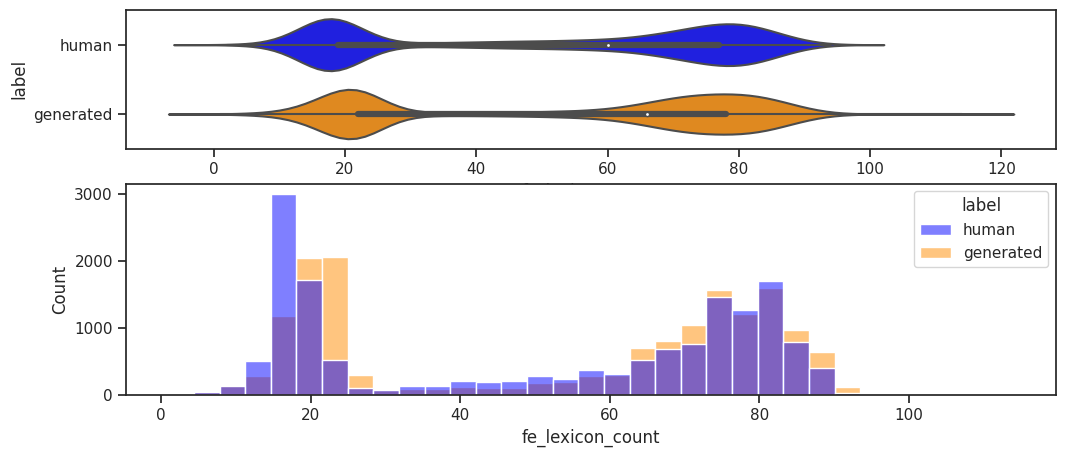

             count       mean        std  min   25%   50%   75%    max

label                                                                 

generated  16275.0  53.188203  27.430523  1.0  22.0  66.0  78.0  114.0

human      15787.0  50.574397  27.956009  2.0  19.0  60.0  77.0   94.0

t-test

Valor t: 8.450012820815259

Valor p: 3.034012662088012e-17

################################################################################


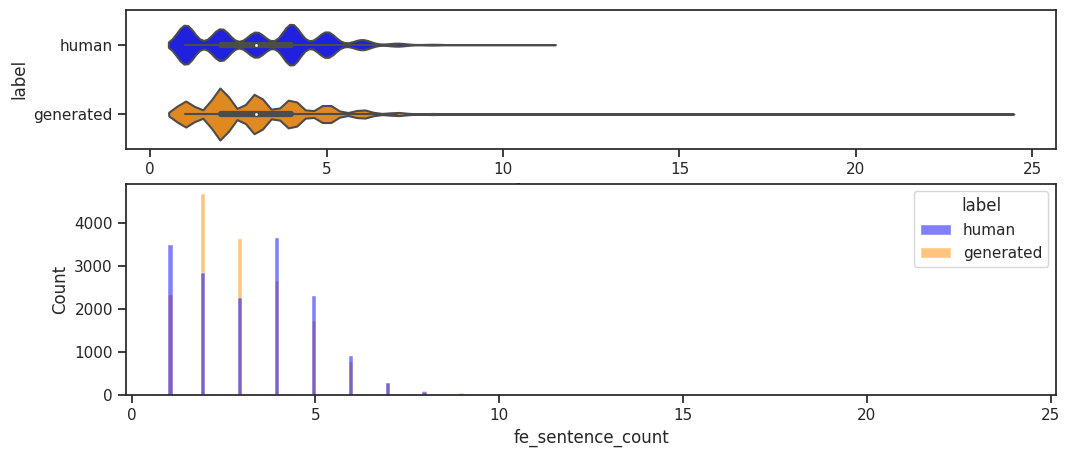

             count      mean       std  min  25%  50%  75%   max

label                                                           

generated  16275.0  3.102058  1.656421  1.0  2.0  3.0  4.0  24.0

human      15787.0  3.173307  1.673794  1.0  2.0  3.0  4.0  11.0

t-test

Valor t: -3.8307051931594707

Valor p: 0.00012801984868404133

################################################################################


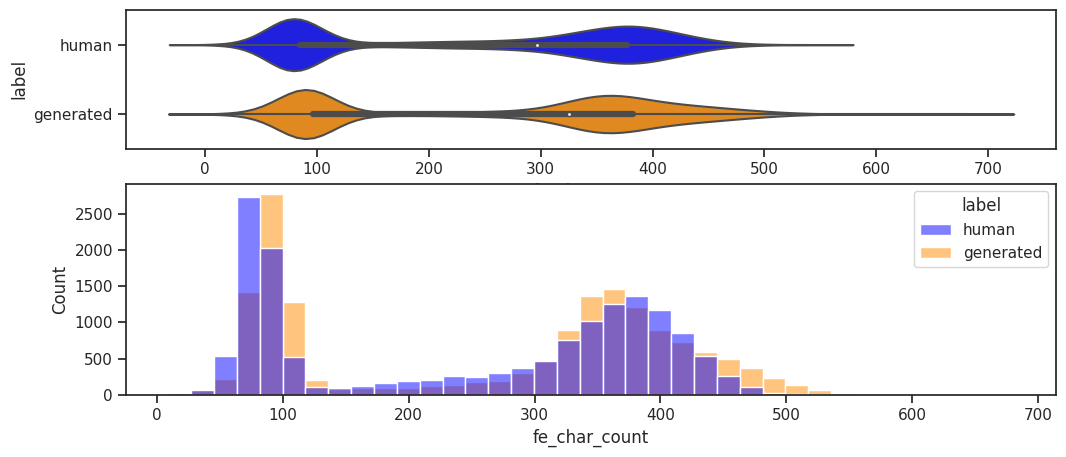

             count        mean         std  min   25%    50%    75%    max

label                                                                     

generated  16275.0  264.294255  145.984890  9.0  96.0  325.0  382.0  681.0

human      15787.0  247.383607  142.513097  9.0  85.0  297.0  377.0  538.0

t-test

Valor t: 10.491835948486507

Valor p: 1.0366776688392885e-25

################################################################################


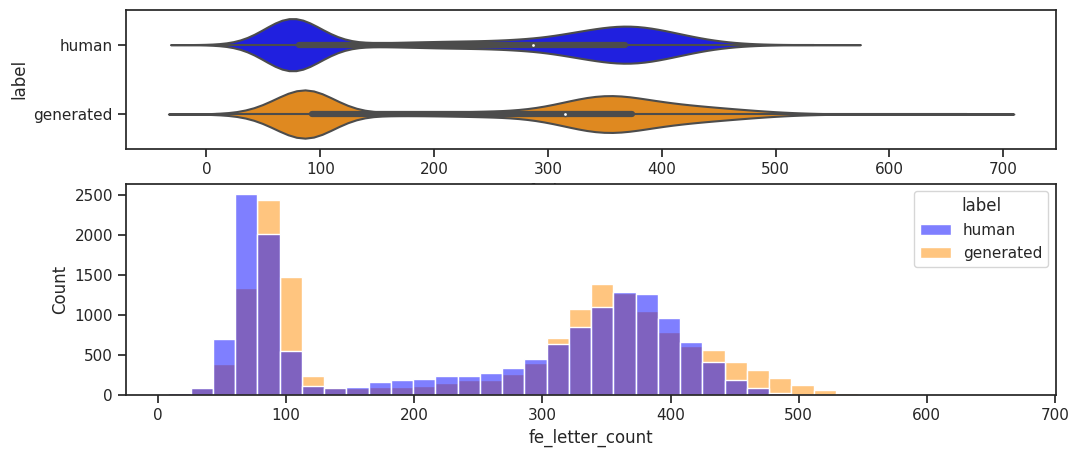

             count        mean         std  min   25%    50%    75%    max

label                                                                     

generated  16275.0  257.115269  144.052768  8.0  93.0  315.0  374.0  668.0

human      15787.0  240.449927  140.248940  9.0  81.0  287.0  368.0  534.0

t-test

Valor t: 10.491859481478892

Valor p: 1.0364203393206652e-25

################################################################################


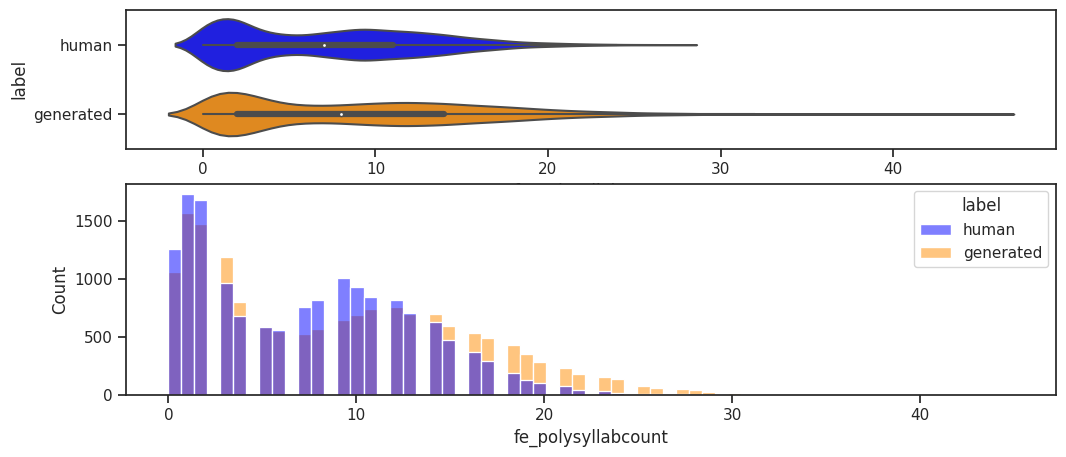

             count      mean       std  min  25%  50%   75%   max

label                                                            

generated  16275.0  8.881413  6.955198  0.0  2.0  8.0  14.0  45.0

human      15787.0  7.287072  5.570659  0.0  2.0  7.0  11.0  27.0

t-test

Valor t: 22.6131588431729

Valor p: 2.4382564210163995e-112

################################################################################


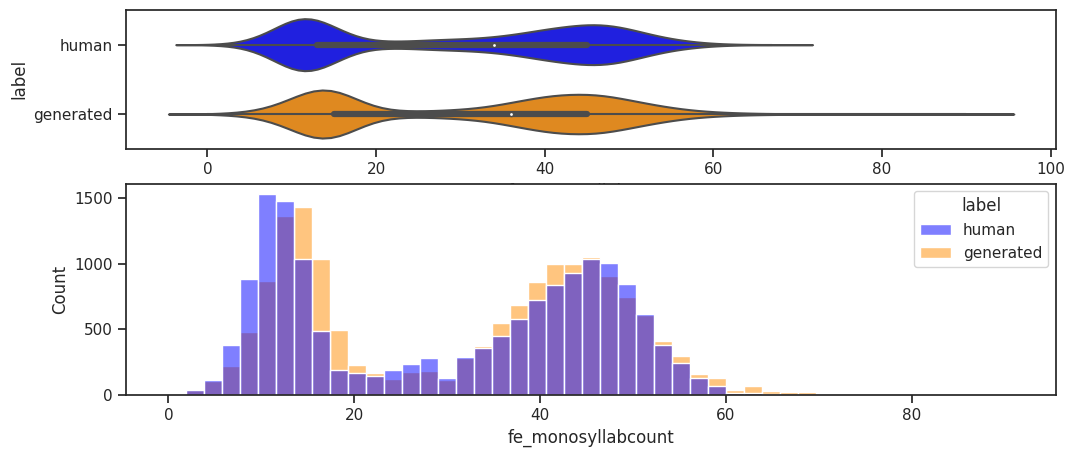

             count       mean        std  min   25%   50%   75%   max

label                                                                

generated  16275.0  31.733763  16.125882  0.0  15.0  36.0  45.0  91.0

human      15787.0  30.315006  16.446641  1.0  13.0  34.0  45.0  67.0

t-test

Valor t: 7.799123317367596

Valor p: 6.422150568515452e-15

################################################################################


In [113]:
for col in ['fe_syllable_count', 'fe_lexicon_count', 'fe_sentence_count', 'fe_char_count', 'fe_letter_count', 'fe_polysyllabcount', 'fe_monosyllabcount']:
  # Realizar el t-test
  train_df_filtered_es_1 = train_df_filtered_es[train_df_filtered_es['label'] == 'generated'].reset_index(drop=True)[col]
  train_df_filtered_es_0 = train_df_filtered_es[train_df_filtered_es['label'] == 'human'].reset_index(drop=True)[col]

  # Realizar el t-test
  t, p     = ttest_ind(list(train_df_filtered_es_1), list(train_df_filtered_es_0))
  color = {"generated": "darkorange", "human": "blue"}
  f, (ax_box, ax_hist) = plt.subplots(2, figsize=(12, 5), gridspec_kw={"height_ratios": (.65, .99)})
  sns.violinplot(data=train_df_filtered_es[train_df_filtered_es[col] > -200], x=col, ax=ax_box, width=0.75, y="label", palette=color) 
  sns.histplot(data=train_df_filtered_es[train_df_filtered_es[col] > -200], x=col, hue="label", ax=ax_hist, palette=color)
  plt.xlabel(col)
  plt.show()

  # Imprimir resultados
  print(train_df_filtered_es.groupby('label')[col].describe())
  print("t-test")
  print('Valor t:', t)
  print('Valor p:', p)
  print("#" * 80)

### Spanish

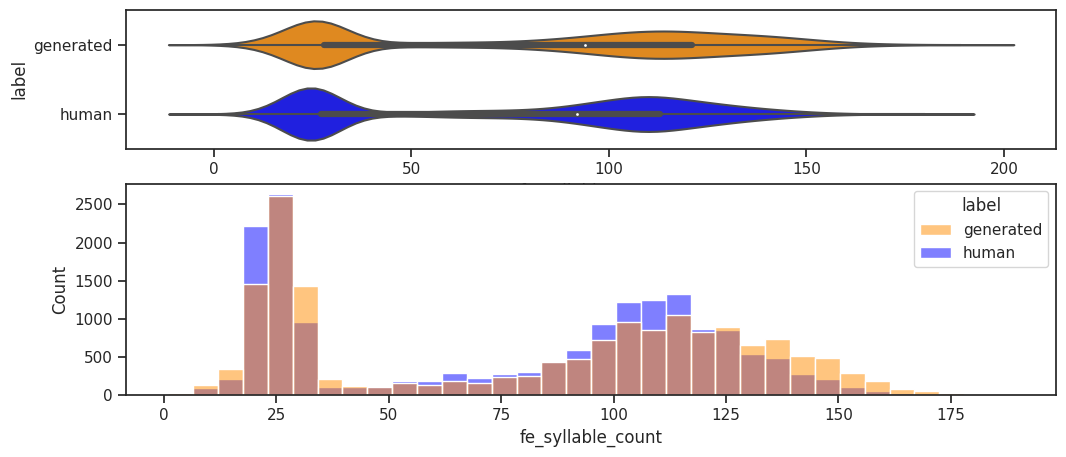

             count       mean        std  min   25%   50%    75%    max

label                                                                  

generated  16799.0  80.539973  47.256149  2.0  28.0  94.0  121.0  189.0

human      17046.0  76.536841  43.691556  1.0  27.0  92.0  113.0  180.0

Valor t: 8.093465544543765

Valor p: 5.991329825171082e-16

################################################################################


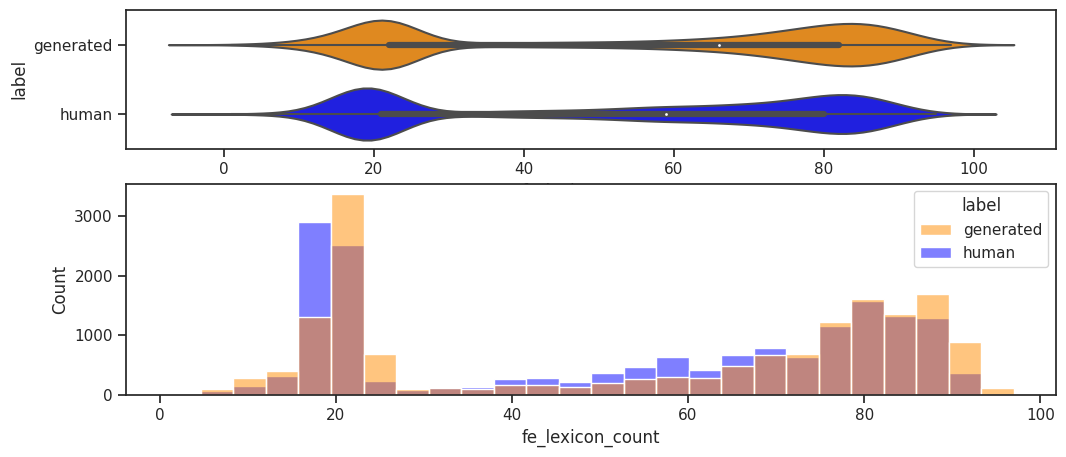

             count       mean        std  min   25%   50%   75%   max

label                                                                

generated  16799.0  54.895887  29.224202  1.0  22.0  66.0  82.0  97.0

human      17046.0  52.137745  28.005377  1.0  21.0  59.0  80.0  95.0

Valor t: 8.865449090601519

Valor p: 7.9840295112695e-19

################################################################################


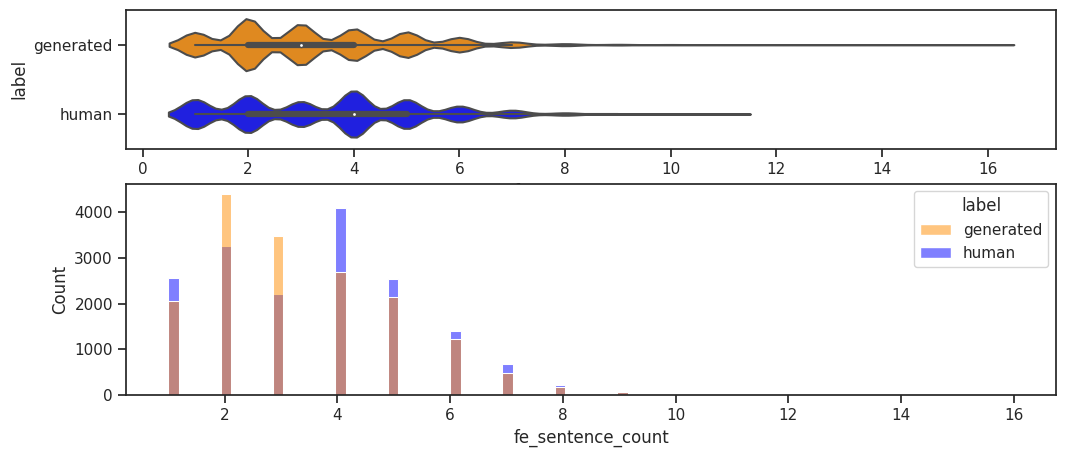

             count      mean       std  min  25%  50%  75%   max

label                                                           

generated  16799.0  3.339246  1.738152  1.0  2.0  3.0  4.0  16.0

human      17046.0  3.544233  1.791577  1.0  2.0  4.0  5.0  11.0

Valor t: -10.681265911323816

Valor p: 1.373333878731504e-26

################################################################################


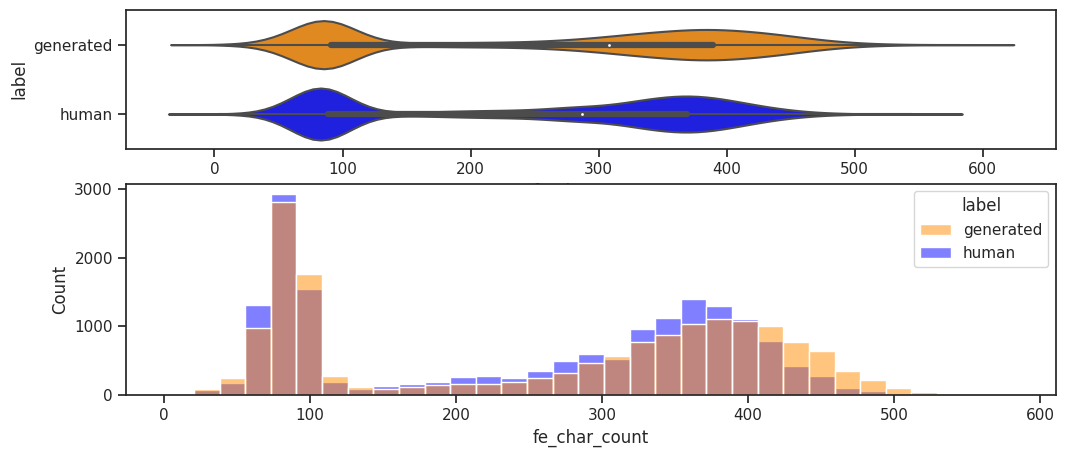

             count        mean         std  min   25%    50%    75%    max

label                                                                     

generated  16799.0  259.394547  147.832394  8.0  91.0  308.0  389.0  582.0

human      17046.0  245.885369  136.787232  3.0  89.0  287.0  369.0  545.0

Valor t: 8.7276207943851

Valor p: 2.717617657079524e-18

################################################################################


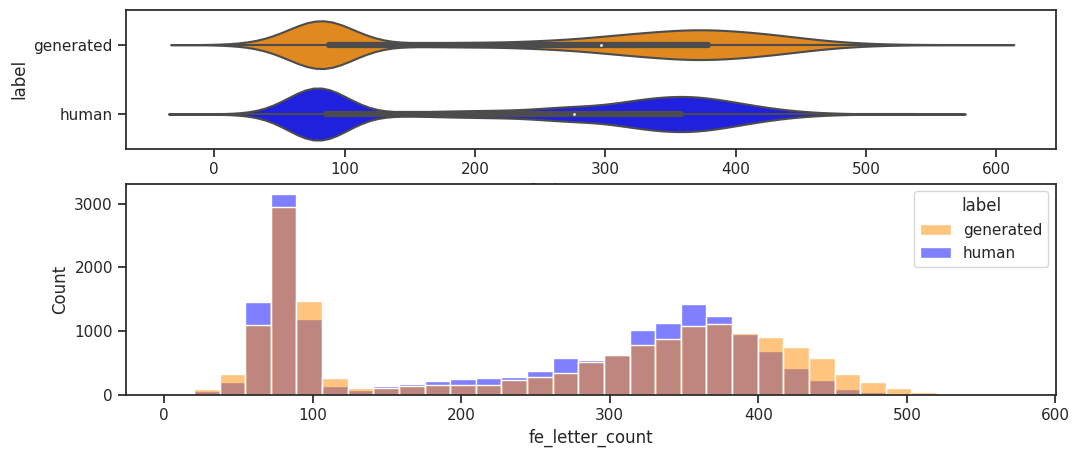

             count        mean         std  min   25%    50%    75%    max

label                                                                     

generated  16799.0  251.488779  144.740221  8.0  88.0  297.0  379.0  572.0

human      17046.0  238.382201  133.675460  3.0  86.0  276.0  358.0  538.0

Valor t: 8.655943825194694

Valor p: 5.100770919082004e-18

################################################################################


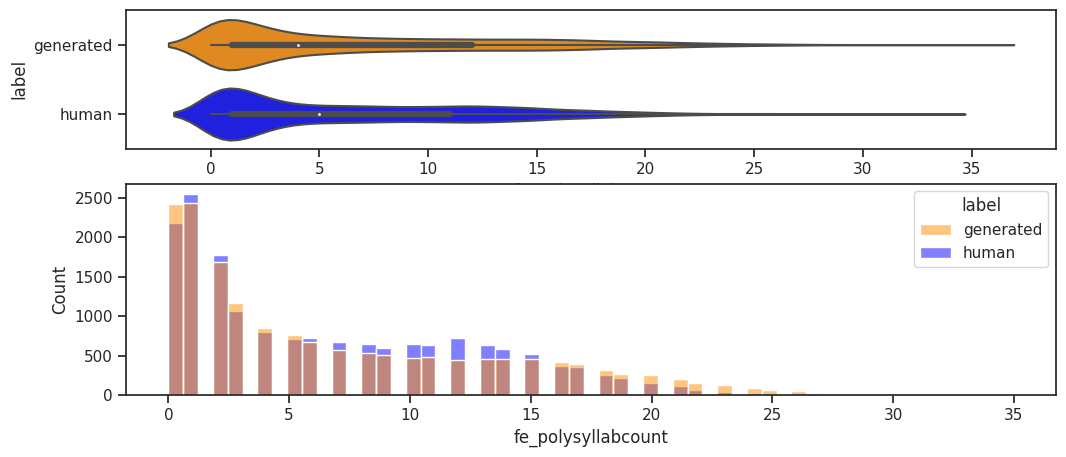

             count      mean       std  min  25%  50%   75%   max

label                                                            

generated  16799.0  6.847015  6.783518  0.0  1.0  4.0  12.0  35.0

human      17046.0  6.524874  5.962654  0.0  1.0  5.0  11.0  33.0

Valor t: 4.642012680303755

Valor p: 3.4632502204452643e-06

################################################################################


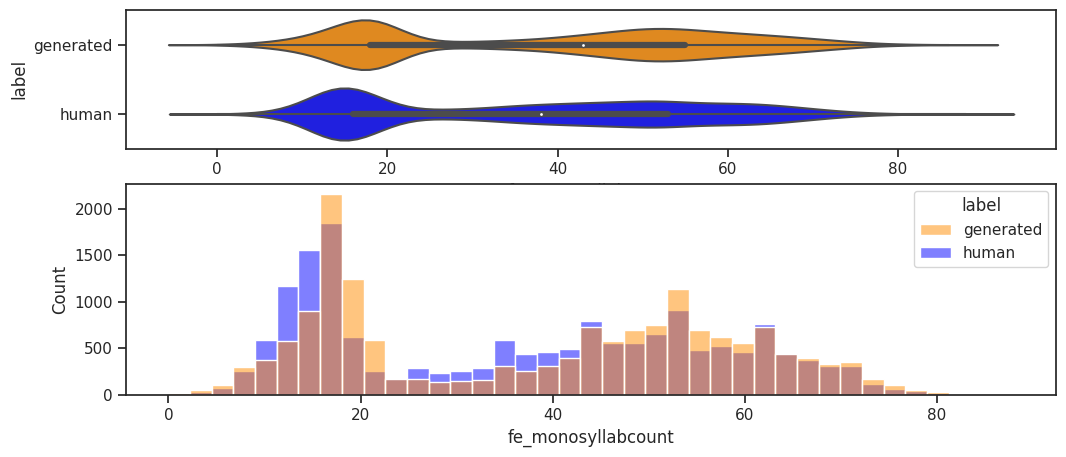

             count       mean        std  min   25%   50%   75%   max

label                                                                

generated  16799.0  38.580273  20.063742  0.0  18.0  43.0  55.0  86.0

human      17046.0  36.541124  19.759289  0.0  16.0  38.0  53.0  88.0

Valor t: 9.42023657061445

Valor p: 4.776045424670228e-21

################################################################################


In [115]:
for col in ['fe_syllable_count', 'fe_lexicon_count', 'fe_sentence_count', 'fe_char_count', 'fe_letter_count', 'fe_polysyllabcount', 'fe_monosyllabcount']:
  # Realizar el t-test
  train_df_filtered_en_1 = train_df_filtered_en[train_df_filtered_en['label'] == 'generated'].reset_index(drop=True)[col]
  train_df_filtered_en_0 = train_df_filtered_en[train_df_filtered_en['label'] == 'human'].reset_index(drop=True)[col]

  # Realizar el t-test
  t, p = ttest_ind(list(train_df_filtered_en_1), list(train_df_filtered_en_0))

  color = {"generated": "darkorange", "human": "blue"}
  f, (ax_box, ax_hist) = plt.subplots(2, figsize=(12, 5), gridspec_kw={"height_ratios": (.65, .99)})
  sns.violinplot(data=train_df_filtered_en[train_df_filtered_en[col] > -200], x=col, ax=ax_box, width=0.75, y="label", palette=color) 
  sns.histplot(data=train_df_filtered_en[train_df_filtered_en[col] > -200], x=col, hue="label", ax=ax_hist, palette=color)
  plt.xlabel(col)
  plt.show()

  # Imprimir resultados
  print(train_df_filtered_en.groupby('label')[col].describe())
  print('Valor t:', t)
  print('Valor p:', p)
  print("#" * 80)

## Sentiment analysis

In [7]:
model_path = "cardiffnlp/twitter-xlm-roberta-base-sentiment"
sentiment_task = pipeline("sentiment-analysis", model=model_path, tokenizer=model_path, device=0, return_all_scores=True)

/opt/conda/lib/python3.7/site-packages/transformers/pipelines/text_classification.py:107: UserWarning: `return_all_scores` is now deprecated,  if want a similar funcionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  UserWarning,


In [41]:
train_df['fe_text_sentiment'] = train_df['text'].progress_apply(lambda x: sentiment_task(x)[0])

  0%|          | 7/65907 [00:00<17:26, 62.97it/s]/opt/conda/lib/python3.7/site-packages/transformers/pipelines/base.py:1073: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  UserWarning,
100%|██████████| 65907/65907 [14:29<00:00, 75.81it/s]


In [42]:
train_df['fe_text_sentiment_neg']  = train_df['fe_text_sentiment'].progress_apply(lambda x: [d for d in x if d['label'] == "negative"][0]['score'])
train_df['fe_text_sentiment_neut'] = train_df['fe_text_sentiment'].progress_apply(lambda x: [d for d in x if d['label'] == "neutral"][0]['score'])
train_df['fe_text_sentiment_pos']  = train_df['fe_text_sentiment'].progress_apply(lambda x: [d for d in x if d['label'] == "positive"][0]['score'])
train_df.drop(['fe_text_sentiment'], axis=1, inplace=True)
train_df

100%|██████████| 65907/65907 [00:00<00:00, 471835.04it/s]


,id,text,label,lang,NOUN,ADP,PUNCT,DET,ADJ,PROPN,...,huerta,IFSZ,polini,mu,minage,SOL,crawford,fe_text_sentiment_neg,fe_text_sentiment_neut,fe_text_sentiment_pos
0,5464,Entrada en vigor. La presente Directiva entrar...,human,es,10,9,7,9,3,8,...,75.653182,77.733485,47.660606,45.986488,7.348389,6.263043,3.374818,0.033826,0.866986,0.099188
1,30129,Preguntas: 1. ¿Cuáles son los principales argu...,generated,es,24,15,11,14,1,2,...,76.599706,75.567353,49.288235,37.894505,7.743371,6.146682,3.837118,0.089444,0.736788,0.173768
2,19553,¿Desea algo? Póngame una caja de madera. ¿Qué ...,generated,es,3,1,9,2,0,2,...,41.335000,57.468333,46.916667,177.400170,8.969867,5.784026,2.901333,0.358786,0.511557,0.129657
3,13005,"@victor28088 1665 Tweets no originales, que as...",human,es,1,0,7,0,2,2,...,97.070294,105.885980,59.551961,68.343287,4.179263,3.257218,0.469471,0.963096,0.027026,0.009878
4,16919,De pequeño Dios me dio a elegir entre tener un...,human,es,2,3,0,2,3,1,...,92.835000,70.069783,49.193478,77.233794,10.425287,10.990268,4.649522,0.180487,0.542082,0.277430
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65902,16850,"@PierreJoye i have a server already, thanks fo...",human,en,5,2,3,3,1,2,...,108.735000,90.270000,54.735000,101.346389,7.888765,5.784026,3.163000,0.099528,0.543954,0.356518
65903,6265,10. Article 13 of Council Directive 80/777/EEC...,human,en,16,20,5,13,1,13,...,106.539545,76.972121,46.464015,56.420948,10.629560,9.868836,3.800955,0.118315,0.817425,0.064260
65904,11284,"Crying because I have to cry for you?. No. No,...",generated,en,0,1,7,0,1,0,...,88.501667,109.785000,65.917778,120.274129,3.473150,1.696099,-1.751444,0.255188,0.566687,0.178124
65905,860,"However, it will continue to offer customers a...",generated,en,27,12,6,5,9,4,...,74.903182,58.263409,33.154773,52.978678,10.866649,10.500186,5.729364,0.349639,0.441585,0.208776


In [43]:
del sentiment_task

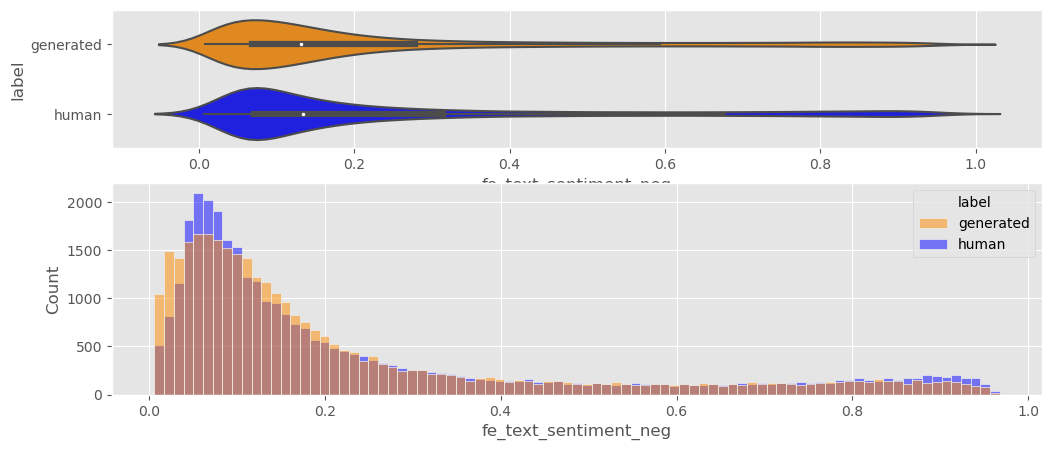

             count      mean       std       min       25%       50%  \
label                                                                  
generated  33074.0  0.227470  0.237651  0.007225  0.068481  0.131874   
human      32833.0  0.246136  0.254691  0.006379  0.071416  0.133959   

                75%       max  
label                          
generated  0.278441  0.965971  
human      0.313875  0.967629  
Valor t: -9.7285079409933
Valor p: 2.359492646300912e-22
################################################################################


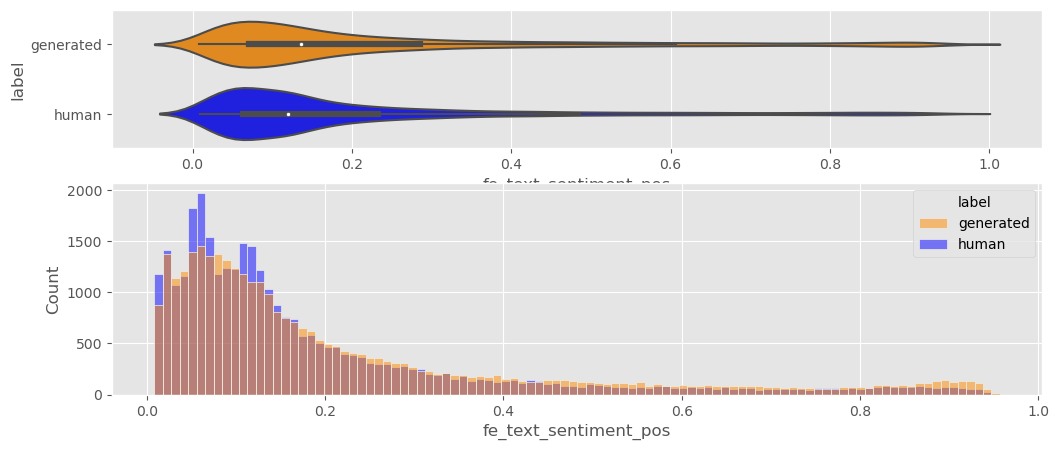

             count      mean       std       min       25%       50%  \
label                                                                  
generated  33074.0  0.224464  0.226643  0.008519  0.070880  0.135492   
human      32833.0  0.192988  0.201091  0.008636  0.063293  0.120094   

                75%       max  
label                          
generated  0.285382  0.956945  
human      0.232613  0.950564  
Valor t: 18.85350649112634
Valor p: 4.4452457217555673e-79
################################################################################


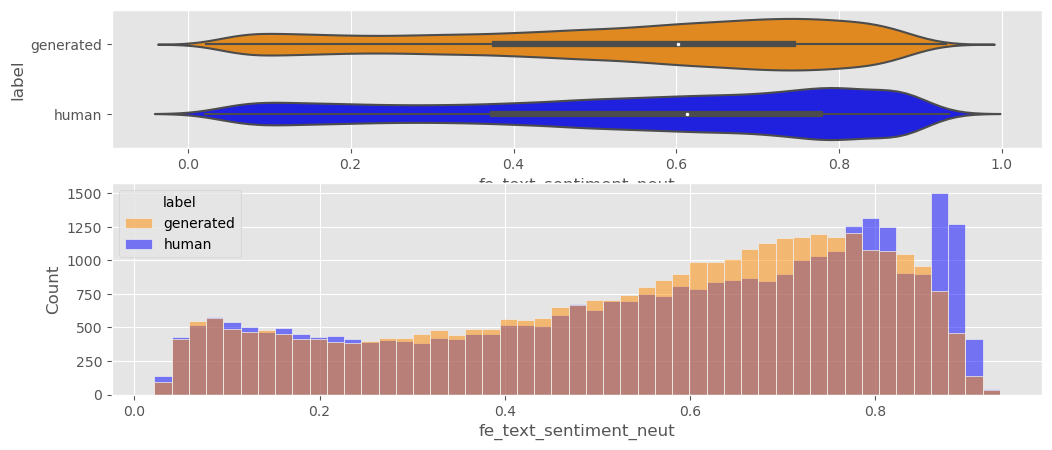

             count      mean       std       min       25%       50%  \
label                                                                  
generated  33074.0  0.548066  0.237102  0.022044  0.377425  0.601579   
human      32833.0  0.560875  0.250831  0.021614  0.374374  0.613561   

                75%       max  
label                          
generated  0.743364  0.931347  
human      0.776737  0.934735  
Valor t: -6.737503732537153
Valor p: 1.6245004453420523e-11
################################################################################


In [35]:
for col in ['fe_text_sentiment_neg', 'fe_text_sentiment_pos', 'fe_text_sentiment_neut']:
  # Realizar el t-test
  train_df_filtered_1 = train_df[train_df['label'] == 'generated'].reset_index(drop=True)[col]
  train_df_filtered_0 = train_df[train_df['label'] == 'human'].reset_index(drop=True)[col]

  # Realizar el t-test
  t, p = ttest_ind(list(train_df_filtered_1), list(train_df_filtered_0))

  color = {"generated": "darkorange", "human": "blue"}
  f, (ax_box, ax_hist) = plt.subplots(2, figsize=(12, 5), gridspec_kw={"height_ratios": (.65, .99)})
  sns.violinplot(data=train_df, x=col, ax=ax_box, width=0.75, y="label", palette=color) 
  sns.histplot(data=train_df, x=col, hue="label", ax=ax_hist, palette=color)
  plt.xlabel(col)
  plt.show()

  # Imprimir resultados
  print(train_df.groupby('label')[col].describe())
  print('Valor t:', t)
  print('Valor p:', p)
  print("#" * 80)

## Emotion analysis

In [9]:
model_path = "MilaNLProc/xlm-emo-t"
emotion_task = pipeline("text-classification", model=model_path, tokenizer=model_path, device=0, return_all_scores=True)

/opt/conda/lib/python3.7/site-packages/transformers/pipelines/text_classification.py:107: UserWarning: `return_all_scores` is now deprecated,  if want a similar funcionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  UserWarning,


In [45]:
train_df['fe_text_emotion'] = train_df['text'].progress_apply(lambda x: emotion_task(x)[0])

  0%|          | 7/65907 [00:00<15:56, 68.91it/s]/opt/conda/lib/python3.7/site-packages/transformers/pipelines/base.py:1073: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  UserWarning,
100%|██████████| 65907/65907 [14:33<00:00, 75.49it/s]


In [46]:
train_df['fe_text_emotion_joy']      = train_df['fe_text_emotion'].progress_apply(lambda x: [d for d in x if d['label'] == "joy"][0]['score'])
train_df['fe_text_emotion_anger']    = train_df['fe_text_emotion'].progress_apply(lambda x: [d for d in x if d['label'] == "anger"][0]['score'])
train_df['fe_text_emotion_sadness']  = train_df['fe_text_emotion'].progress_apply(lambda x: [d for d in x if d['label'] == "sadness"][0]['score'])
train_df['fe_text_emotion_fear']     = train_df['fe_text_emotion'].progress_apply(lambda x: [d for d in x if d['label'] == "fear"][0]['score'])
train_df.drop(['fe_text_emotion'], axis=1, inplace=True)
train_df

100%|██████████| 65907/65907 [00:00<00:00, 281243.25it/s]


,id,text,label,lang,NOUN,ADP,PUNCT,DET,ADJ,PROPN,...,minage,SOL,crawford,fe_text_sentiment_neg,fe_text_sentiment_neut,fe_text_sentiment_pos,fe_text_emotion_joy,fe_text_emotion_anger,fe_text_emotion_sadness,fe_text_emotion_fear
0,5464,Entrada en vigor. La presente Directiva entrar...,human,es,10,9,7,9,3,8,...,7.348389,6.263043,3.374818,0.033826,0.866986,0.099188,0.360500,0.498721,0.043040,0.097739
1,30129,Preguntas: 1. ¿Cuáles son los principales argu...,generated,es,24,15,11,14,1,2,...,7.743371,6.146682,3.837118,0.089444,0.736788,0.173768,0.752865,0.165838,0.041303,0.039994
2,19553,¿Desea algo? Póngame una caja de madera. ¿Qué ...,generated,es,3,1,9,2,0,2,...,8.969867,5.784026,2.901333,0.358786,0.511557,0.129657,0.008273,0.983991,0.002862,0.004874
3,13005,"@victor28088 1665 Tweets no originales, que as...",human,es,1,0,7,0,2,2,...,4.179263,3.257218,0.469471,0.963096,0.027026,0.009878,0.003797,0.992575,0.002762,0.000867
4,16919,De pequeño Dios me dio a elegir entre tener un...,human,es,2,3,0,2,3,1,...,10.425287,10.990268,4.649522,0.180487,0.542082,0.277430,0.578281,0.011191,0.339997,0.070531
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65902,16850,"@PierreJoye i have a server already, thanks fo...",human,en,5,2,3,3,1,2,...,7.888765,5.784026,3.163000,0.099528,0.543954,0.356518,0.656969,0.114904,0.209541,0.018586
65903,6265,10. Article 13 of Council Directive 80/777/EEC...,human,en,16,20,5,13,1,13,...,10.629560,9.868836,3.800955,0.118315,0.817425,0.064260,0.343669,0.460107,0.140876,0.055348
65904,11284,"Crying because I have to cry for you?. No. No,...",generated,en,0,1,7,0,1,0,...,3.473150,1.696099,-1.751444,0.255188,0.566687,0.178124,0.019957,0.004248,0.970996,0.004800
65905,860,"However, it will continue to offer customers a...",generated,en,27,12,6,5,9,4,...,10.866649,10.500186,5.729364,0.349639,0.441585,0.208776,0.262605,0.054364,0.012479,0.670552


In [47]:
del emotion_task

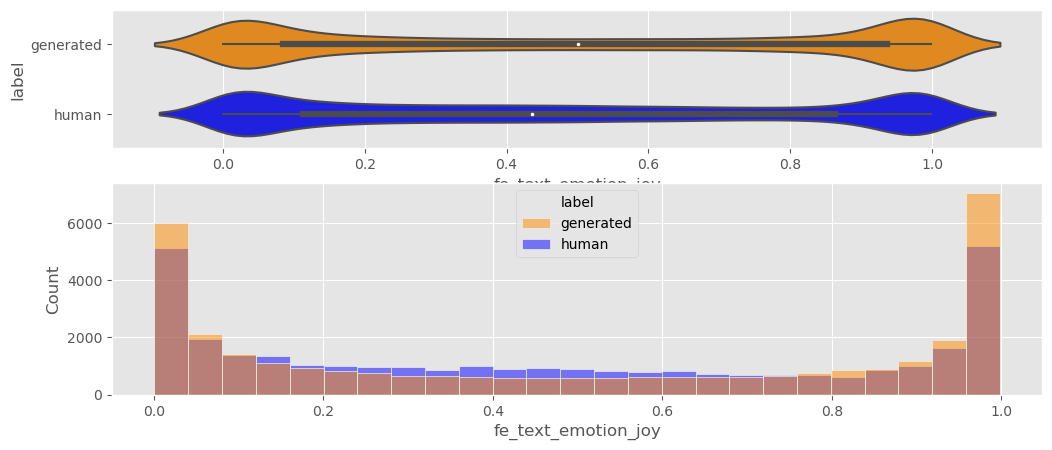

             count      mean       std       min       25%       50%  \
label                                                                  
generated  33074.0  0.504825  0.389683  0.000613  0.084660  0.501188   
human      32833.0  0.474300  0.362439  0.000681  0.112896  0.435680   

                75%       max  
label                          
generated  0.935997  0.998249  
human      0.863186  0.998224  
Valor t: 10.41070955676249
Valor p: 2.3183840361636047e-25
################################################################################


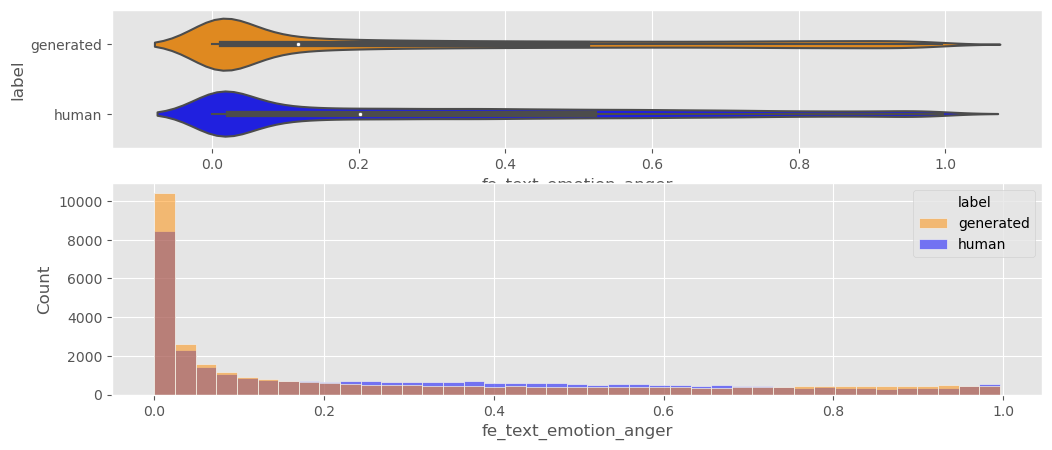

             count      mean       std       min       25%       50%  \
label                                                                  
generated  33074.0  0.277218  0.315306  0.000335  0.013184  0.117725   
human      32833.0  0.298905  0.300436  0.000318  0.022969  0.202560   

                75%       max  
label                          
generated  0.510675  0.995501  
human      0.521558  0.996052  
Valor t: -9.038642657745243
Valor p: 1.6279354312673948e-19
################################################################################


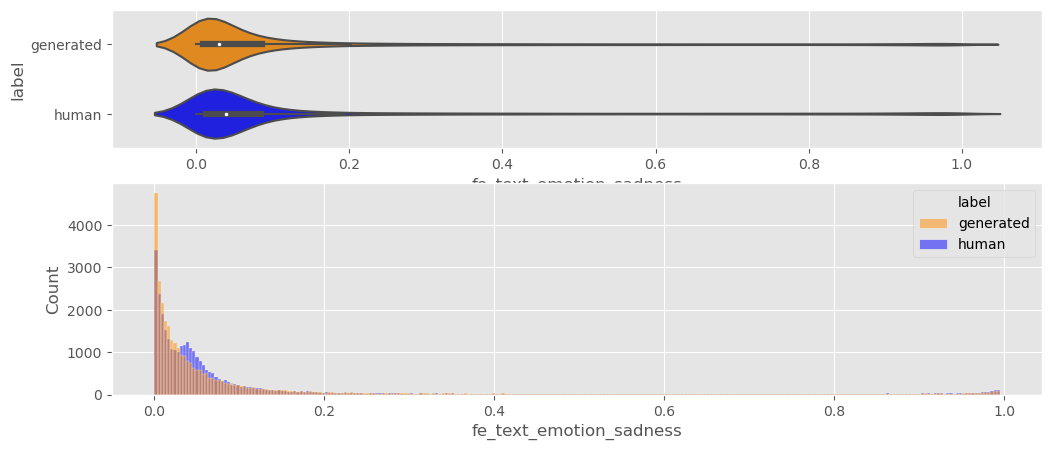

             count      mean       std       min       25%       50%  \
label                                                                  
generated  33074.0  0.110489  0.210210  0.000588  0.009318  0.030297   
human      32833.0  0.117967  0.219688  0.000629  0.013038  0.039240   

                75%       max  
label                          
generated  0.086612  0.994641  
human      0.085357  0.994715  
Valor t: -4.46499033882139
Valor p: 8.020506622799142e-06
################################################################################


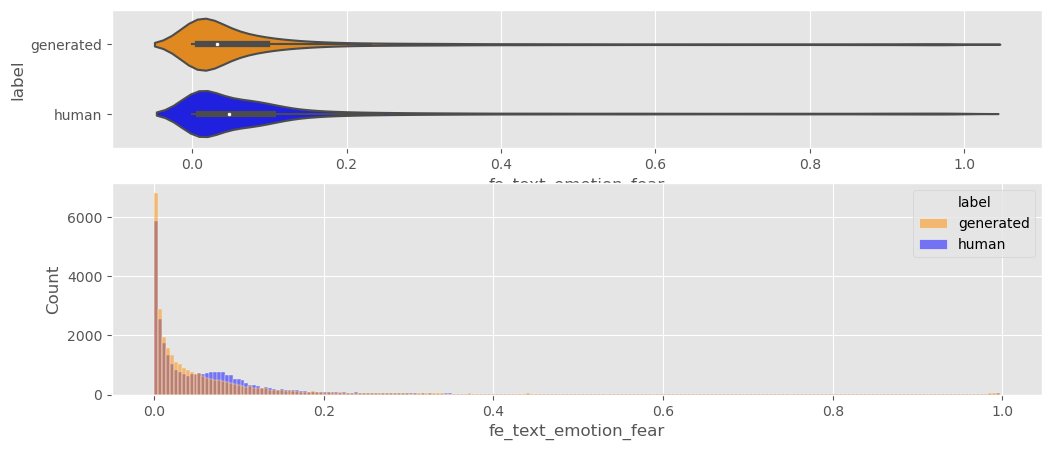

             count      mean       std       min       25%       50%  \
label                                                                  
generated  33074.0  0.107469  0.197021  0.000290  0.006925  0.031944   
human      32833.0  0.108828  0.186743  0.000287  0.009028  0.048175   

                75%       max  
label                          
generated  0.096976  0.996973  
human      0.104311  0.997061  
Valor t: -0.9087677367815714
Valor p: 0.36347606340265215
################################################################################


In [13]:
for col in ['fe_text_emotion_joy', 'fe_text_emotion_anger', 'fe_text_emotion_sadness', 'fe_text_emotion_fear']:
  # Realizar el t-test
  train_df_filtered_1 = train_df[train_df['label'] == 'generated'].reset_index(drop=True)[col]
  train_df_filtered_0 = train_df[train_df['label'] == 'human'].reset_index(drop=True)[col]

  # Realizar el t-test
  t, p = ttest_ind(list(train_df_filtered_1), list(train_df_filtered_0))

  color = {"generated": "darkorange", "human": "blue"}
  f, (ax_box, ax_hist) = plt.subplots(2, figsize=(12, 5), gridspec_kw={"height_ratios": (.65, .99)})
  sns.violinplot(data=train_df, x=col, ax=ax_box, width=0.75, y="label", palette=color) 
  sns.histplot(data=train_df, x=col, hue="label", ax=ax_hist, palette=color)
  plt.xlabel(col)
  plt.show()

  # Imprimir resultados
  print(train_df.groupby('label')[col].describe())
  print('Valor t:', t)
  print('Valor p:', p)
  print("#" * 80)

## Detoxify for toxic comments

In [18]:
model = Detoxify('multilingual', device='cuda')

Downloading: "https://github.com/unitaryai/detoxify/releases/download/v0.4-alpha/multilingual_debiased-0b549669.ckpt" to /root/.cache/torch/hub/checkpoints/multilingual_debiased-0b549669.ckpt


  0%|          | 0.00/1.04G [00:00<?, ?B/s]

In [58]:
train_df['fe_detoxify'] = train_df['text'].progress_apply(lambda x: model.predict([x]))

100%|██████████| 65907/65907 [17:04<00:00, 64.35it/s]


In [62]:
keys = ['toxicity', 'severe_toxicity', 'obscene', 'identity_attack', 'insult', 'threat', 'sexual_explicit']
for k in keys:
    train_df[k] = train_df['fe_detoxify'].progress_apply(lambda x: x[k][0])

100%|██████████| 65907/65907 [00:00<00:00, 527224.83it/s]


In [64]:
train_df.drop(['fe_detoxify'], axis=1, inplace=True)

In [66]:
train_df.to_csv('train_df.csv', sep=';', index=False)

## Feature Engineering with test set

In [7]:
test_df_es = pd.read_csv('/kaggle/input/test-set-autextification-subtask1/test.tsv-2/test.tsv', sep='\t')
test_df_es['lang'] = 'es'
test_df_en = pd.read_csv('/kaggle/input/test-set-autextification-subtask1/test.tsv', sep='\t')
test_df_en['lang'] = 'en'

In [8]:
test_df_es['ca_es'] = test_df_es['text'].progress_apply(lambda x: get_metrics(x, lang="es"))
test_df_en['ca_en'] = test_df_en['text'].progress_apply(lambda x: get_metrics(x, lang="en"))

100%|██████████| 21832/21832 [17:58<00:00, 20.24it/s]


In [10]:
for k in keys:
    test_df_en[k] = test_df_en['ca_en'].progress_apply(lambda x: x[k])
    test_df_es[k] = test_df_es['ca_es'].progress_apply(lambda x: x[k])
test_df_en.drop(['ca_en'], axis=1, inplace=True)
test_df_es.drop(['ca_es'], axis=1, inplace=True)

100%|██████████| 20129/20129 [00:00<00:00, 619657.87it/s]


In [13]:
# Carga el modelo de spaCy para el idioma que estés utilizando
nlp = spacy.load('es_core_news_sm')

tqdm.pandas()
for k in pos_list:
    test_df_es[k] = test_df_es['text'].progress_apply(lambda x: len([token.pos_ for token in nlp(x) if token.pos_ == k]))

# Carga el modelo de spaCy para el idioma que estés utilizando 8
nlp = spacy.load('en_core_web_sm')

for k in pos_list:
    test_df_en[k] = test_df_en['text'].progress_apply(lambda x: len([token.pos_ for token in nlp(x) if token.pos_ == k]))

100%|██████████| 21832/21832 [05:09<00:00, 70.50it/s]


In [ ]:
test_df = pd.concat([test_df_es, test_df_en])

In [8]:
# -- Sentiment task
test_df['fe_text_sentiment']      = test_df['text'].progress_apply(lambda x: sentiment_task(x)[0])
test_df['fe_text_sentiment_neg']  = test_df['fe_text_sentiment'].progress_apply(lambda x: [d for d in x if d['label'] == "negative"][0]['score'])
test_df['fe_text_sentiment_neut'] = test_df['fe_text_sentiment'].progress_apply(lambda x: [d for d in x if d['label'] == "neutral"][0]['score'])
test_df['fe_text_sentiment_pos']  = test_df['fe_text_sentiment'].progress_apply(lambda x: [d for d in x if d['label'] == "positive"][0]['score'])
test_df.drop(['fe_text_sentiment'], axis=1, inplace=True)
test_df

  0%|          | 8/41961 [00:02<2:20:14,  4.99it/s] /opt/conda/lib/python3.7/site-packages/transformers/pipelines/base.py:1073: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  UserWarning,
100%|██████████| 41961/41961 [00:00<00:00, 512352.52it/s]


,id,text,lang,npunct,nword,ILFW,LDI,LC,nrword,SSR,...,PRON,CCONJ,SCONJ,SYM,PART,INTJ,X,fe_text_sentiment_neg,fe_text_sentiment_neut,fe_text_sentiment_pos
0,17414,Buscábamos tranquilidad y la encontramos. Me t...,es,5,51,0.913043,3.500000,2.206522,21,172.300029,...,4,5,1,0,0,0,0,0.428791,0.264489,0.306721
1,16938,"Nos sorprendió la cena, si vas con media pensi...",es,6,58,0.923077,6.000000,3.461538,24,182.627052,...,6,2,2,0,0,0,0,0.035553,0.092597,0.871850
2,17379,Servicio atento y magnificas vistas al rio.,es,1,7,1.000000,4.000000,2.500000,4,222.863000,...,0,1,0,0,0,0,0,0.014796,0.054916,0.930288
3,5391,La Oficina Nacional de Estadísticas de China d...,es,7,88,0.775000,13.333333,7.054167,31,186.081424,...,5,2,0,0,0,0,0,0.552206,0.408393,0.039400
4,17310,Pero no puedes tener a una sola persona sirvie...,es,4,42,0.588235,4.250000,2.419118,9,109.994500,...,3,4,1,0,0,1,0,0.623608,0.295519,0.080873
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41956,11964,"However, it still has some great songs that yo...",en,6,47,1.000000,3.200000,2.100000,18,164.196940,...,8,0,1,0,1,0,0,0.015890,0.052483,0.931627
41957,21575,I bought the product because I wanted to see i...,en,6,74,1.000000,3.666667,2.333333,28,167.390279,...,16,2,2,0,3,0,0,0.374741,0.414691,0.210568
41958,5390,This will make it easier for us to plan adequa...,en,3,45,1.000000,6.000000,3.500000,19,186.228333,...,7,0,3,0,2,0,0,0.109942,0.365747,0.524312
41959,860,"The plans include new emergency departments, a...",en,4,88,1.000000,10.250000,5.625000,42,215.757091,...,3,3,2,2,3,0,0,0.209631,0.497858,0.292512


In [10]:
del sentiment_task

In [12]:
# -- Emotion task
test_df['fe_text_emotion']          = test_df['text'].progress_apply(lambda x: emotion_task(x)[0])
test_df['fe_text_emotion_joy']      = test_df['fe_text_emotion'].progress_apply(lambda x: [d for d in x if d['label'] == "joy"][0]['score'])
test_df['fe_text_emotion_anger']    = test_df['fe_text_emotion'].progress_apply(lambda x: [d for d in x if d['label'] == "anger"][0]['score'])
test_df['fe_text_emotion_sadness']  = test_df['fe_text_emotion'].progress_apply(lambda x: [d for d in x if d['label'] == "sadness"][0]['score'])
test_df['fe_text_emotion_fear']     = test_df['fe_text_emotion'].progress_apply(lambda x: [d for d in x if d['label'] == "fear"][0]['score'])
test_df.drop(['fe_text_emotion'], axis=1, inplace=True)
test_df

  0%|          | 7/41961 [00:00<11:14, 62.23it/s]/opt/conda/lib/python3.7/site-packages/transformers/pipelines/base.py:1073: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  UserWarning,
100%|██████████| 41961/41961 [00:00<00:00, 473123.44it/s]


,id,text,lang,npunct,nword,ILFW,LDI,LC,nrword,SSR,...,PART,INTJ,X,fe_text_sentiment_neg,fe_text_sentiment_neut,fe_text_sentiment_pos,fe_text_emotion_joy,fe_text_emotion_anger,fe_text_emotion_sadness,fe_text_emotion_fear
0,17414,Buscábamos tranquilidad y la encontramos. Me t...,es,5,51,0.913043,3.500000,2.206522,21,172.300029,...,0,0,0,0.428791,0.264489,0.306721,0.957731,0.001054,0.005975,0.035239
1,16938,"Nos sorprendió la cena, si vas con media pensi...",es,6,58,0.923077,6.000000,3.461538,24,182.627052,...,0,0,0,0.035553,0.092597,0.871850,0.992328,0.004888,0.001024,0.001761
2,17379,Servicio atento y magnificas vistas al rio.,es,1,7,1.000000,4.000000,2.500000,4,222.863000,...,0,0,0,0.014796,0.054916,0.930288,0.994708,0.001779,0.001271,0.002243
3,5391,La Oficina Nacional de Estadísticas de China d...,es,7,88,0.775000,13.333333,7.054167,31,186.081424,...,0,0,0,0.552206,0.408393,0.039400,0.002170,0.014409,0.050129,0.933292
4,17310,Pero no puedes tener a una sola persona sirvie...,es,4,42,0.588235,4.250000,2.419118,9,109.994500,...,0,1,0,0.623608,0.295519,0.080873,0.275759,0.334030,0.374384,0.015827
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41956,11964,"However, it still has some great songs that yo...",en,6,47,1.000000,3.200000,2.100000,18,164.196940,...,1,0,0,0.015890,0.052483,0.931627,0.996967,0.000669,0.001722,0.000642
41957,21575,I bought the product because I wanted to see i...,en,6,74,1.000000,3.666667,2.333333,28,167.390279,...,3,0,0,0.374741,0.414691,0.210568,0.984648,0.001839,0.008161,0.005352
41958,5390,This will make it easier for us to plan adequa...,en,3,45,1.000000,6.000000,3.500000,19,186.228333,...,2,0,0,0.109942,0.365747,0.524312,0.895414,0.013602,0.036341,0.054643
41959,860,"The plans include new emergency departments, a...",en,4,88,1.000000,10.250000,5.625000,42,215.757091,...,3,0,0,0.209631,0.497858,0.292512,0.899258,0.028186,0.035889,0.036667


In [13]:
del emotion_task

In [19]:
# -- Detoxify
test_df['fe_detoxify'] = test_df['text'].progress_apply(lambda x: model.predict([x]))
keys = ['toxicity', 'severe_toxicity', 'obscene', 'identity_attack', 'insult', 'threat', 'sexual_explicit']
for k in keys:
    test_df[k] = test_df['fe_detoxify'].progress_apply(lambda x: x[k][0])
test_df.drop(['fe_detoxify'], axis=1, inplace=True)

100%|██████████| 41961/41961 [00:00<00:00, 670067.27it/s]


In [23]:
test_df.to_csv('autextification_df_test.csv', sep=';', index=False)